# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

customers.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 1.1: Exploring the Data

In [5]:
df_azdias = pd.DataFrame(azdias)

In [6]:
df_customers = pd.DataFrame(customers)

In [7]:
# create and use random samples for the customers and azdias datasets due to performance issues:
df_customers = df_customers.sample(n= 50000, random_state=42)
df_customers.shape

(50000, 369)

In [8]:
# create a random sample consisting of  5000 datapoints due to performance issues
# it takes time but it works, about 7 minutes
df_azdias = df_azdias.sample(n= 50000, random_state=42)
df_azdias.shape

(50000, 366)

In [9]:
df_azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
364459,839311,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
329428,1023911,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,13.0,...,3.0,10.0,7.0,4.0,NaN,9.0,2.0,3,2,4
724532,444319,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
125751,387114,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,12.0,...,2.0,9.0,12.0,9.0,6.0,8.0,5.0,5,2,2
91110,1073128,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,...,4.0,6.0,7.0,4.0,1.0,9.0,3.0,3,2,3


In [10]:
df_customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
162743,117671,3,1.0,13.0,NaN,NaN,NaN,NaN,12.0,2.0,...,4.0,4.0,9.0,4.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,3
82524,74233,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,3.0,...,4.0,4.0,9.0,7.0,6,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
166362,132179,-1,1.0,0.0,NaN,NaN,NaN,NaN,15.0,1.0,...,4.0,4.0,9.0,5.0,1,FOOD,SINGLE_BUYER,0,1,3
165859,122832,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,1
96065,73366,-1,1.0,16.0,NaN,NaN,NaN,NaN,16.0,10.0,...,4.0,2.0,9.0,3.0,4,COSMETIC_AND_FOOD,MULTI_BUYER,1,1,2


In [11]:
df_azdias.shape

(50000, 366)

In [12]:
df_customers.shape

(50000, 369)

In [13]:
df_azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,5.000000e+04,50000.000000,45779.000000,45779.000000,4506.000000,1606.000000,349.000000,74.000000,35140.000000,44669.000000,...,43147.000000,45644.000000,45644.000000,45644.000000,43810.000000,45779.000000,44669.000000,50000.000000,50000.000000,50000.000000
mean,6.347478e+05,-0.354220,4.417091,10.832696,11.774745,13.555417,14.719198,15.445946,13.631446,8.357989,...,2.412659,6.034681,7.569056,5.965340,3.939169,7.910505,4.060937,3.368520,1.518780,2.780160
std,2.586020e+05,1.204067,3.641530,7.642482,4.051729,3.189602,2.497402,2.202999,5.127748,16.237802,...,1.163455,2.850649,3.242627,2.767828,1.960549,1.920844,1.946507,1.350922,0.499652,1.062098
min,1.916720e+05,-1.000000,1.000000,0.000000,2.000000,3.000000,7.000000,9.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.102668e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,4.000000,6.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.337150e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,16.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.592248e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,10.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082872e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [14]:
df_customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,50000.000000,50000.000000,37773.000000,37773.000000,3024.000000,1310.000000,311.000000,60.000000,36410.000000,36918.000000,...,37428.000000,37428.000000,37428.000000,35936.000000,37773.000000,36918.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,95561.765600,0.337800,1.758240,11.341805,12.281415,13.637405,14.758842,15.766667,10.321587,4.998564,...,4.393582,4.591589,3.193705,4.149321,8.643793,3.723414,2.57868,0.091140,1.377600,3.061880
std,55210.032331,1.391765,1.978615,6.300049,4.030873,3.267635,2.614422,2.257692,4.174033,14.477483,...,2.930465,2.897576,2.246931,1.974505,1.158587,2.088429,1.17250,0.287811,0.484792,1.083658
min,4.000000,-1.000000,1.000000,0.000000,2.000000,3.000000,7.000000,10.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,1.000000
25%,47893.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.00000,0.000000,1.000000,3.000000
50%,95077.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,17.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.00000,0.000000,1.000000,3.000000
75%,143615.500000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,18.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.00000,0.000000,2.000000,4.000000
max,191649.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,10.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.00000,1.000000,2.000000,9.000000


In [ ]:
print(df_customers.transpose())

In [ ]:
df_customers.info()

In [7]:
# accepts minimum non-Na values in rows, here atleast 10 values are Nan
# based on the .shape and its columns
df_customers_droppedna = df_customers.dropna(thresh=357)
df_customers.shape

(50000, 369)

In [8]:
# accepts minimum non-Na values in rows, here atleast 10 values are Nan
# based on the .shape and its columns
df_azdias_droppedna = df_azdias.dropna(thresh=357)
df_azdias.shape

(50000, 366)

In [9]:
# method to replace with median
def replace_Nan_with_median (df, column_list):
    
    for i in column_list:
        #print('i:::',column_name)
        median = df[i].median()
        df[i] =  df[i].fillna(median)
        #return new_df[column_name]
    print(df)
    return df

In [10]:
# create variables with column names list based on datatypes   
customers_int_float_columns = [key for key in dict(df_customers_droppedna.dtypes) if dict(df_customers_droppedna.dtypes)[key] in ['int64', 'float64']]

customers_categorical_columns = [key for key in dict(df_customers_droppedna.dtypes) if dict(df_customers_droppedna.dtypes)[key] in ['object']]


In [11]:
# create variables with column names list based on datatypes   
azdias_int_float_columns = [key for key in dict(df_azdias_droppedna.dtypes) if dict(df_azdias_droppedna.dtypes)[key] in ['int64', 'float64']]

azdias_categorical_columns = [key for key in dict(df_azdias_droppedna.dtypes) if dict(df_azdias_droppedna.dtypes)[key] in ['object']]
azdias_categorical_columns

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [12]:
replace_Nan_with_median(df_customers_droppedna, customers_int_float_columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


           LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
10433    39189        -1         1.0      15.0         13.0         14.0   
141181  185712         1         1.0      16.0         13.0         14.0   
29197    34728         2         2.0      11.0         13.0         14.0   
122619   58274        -1         1.0       0.0         13.0         14.0   
162388   36894        -1         1.0       0.0         13.0         14.0   
26294   136611         1         1.0      19.0         13.0         14.0   
100083  172447         2         1.0      10.0         13.0         14.0   
65459   126626        -1         1.0      20.0         13.0         14.0   
177209  156244        -1         7.0      15.0         13.0         14.0   
107008   24055         1         1.0       8.0         13.0         14.0   
82659    96311         1         1.0      10.0         13.0         14.0   
27228   128463         2         1.0       8.0         13.0         14.0   
184780   467

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
10433,39189,-1,1.0,15.0,13.0,14.0,15.0,16.0,15.0,10.0,...,2.0,4.0,9.0,3.0,4,COSMETIC,MULTI_BUYER,0,2,4
141181,185712,1,1.0,16.0,13.0,14.0,15.0,16.0,10.0,1.0,...,3.0,2.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
29197,34728,2,2.0,11.0,13.0,14.0,15.0,16.0,10.0,2.0,...,1.0,6.0,9.0,4.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
122619,58274,-1,1.0,0.0,13.0,14.0,15.0,16.0,0.0,1.0,...,5.0,6.0,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
162388,36894,-1,1.0,0.0,13.0,14.0,15.0,16.0,16.0,1.0,...,3.0,2.0,9.0,4.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
26294,136611,1,1.0,19.0,13.0,14.0,15.0,16.0,10.0,1.0,...,1.0,2.0,9.0,2.0,1,COSMETIC,MULTI_BUYER,0,1,4
100083,172447,2,1.0,10.0,13.0,14.0,15.0,16.0,10.0,3.0,...,3.0,6.0,9.0,4.0,6,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
65459,126626,-1,1.0,20.0,13.0,14.0,15.0,16.0,20.0,13.0,...,5.0,2.0,9.0,2.0,4,COSMETIC,SINGLE_BUYER,1,2,1
177209,156244,-1,7.0,15.0,13.0,14.0,15.0,16.0,15.0,2.0,...,6.0,5.0,4.0,4.0,4,FOOD,SINGLE_BUYER,1,1,3
107008,24055,1,1.0,8.0,13.0,14.0,15.0,16.0,8.0,1.0,...,3.0,6.0,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [13]:
replace_Nan_with_median(df_azdias_droppedna, azdias_int_float_columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
821104   210067        -1         7.0      17.0         12.0         14.0   
192165   340571         2         6.0      16.0         18.0         14.0   
582470   640852         2         1.0      11.0         12.0         14.0   
416290   364225        -1         6.0      18.0         12.0         14.0   
63624    782755        -1         9.0      14.0         12.0         14.0   
672688   735899        -1         1.0      18.0          6.0         11.0   
594103   293324        -1         1.0      16.0         12.0         14.0   
200006   933106        -1         9.0       0.0         12.0         14.0   
355623   833757        -1         5.0      20.0         12.0         14.0   
483455   708900         1         1.0      11.0         12.0         14.0   
13907    710289        -1         7.0      19.0         12.0         14.0   
546492   417165        -1         1.0      20.0         12.0         14.0   

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
821104,210067,-1,7.0,17.0,12.0,14.0,15.0,15.0,17.0,6.0,...,2.0,3.0,5.0,4.0,2.0,5.0,3.0,4,2,1
192165,340571,2,6.0,16.0,18.0,14.0,15.0,15.0,11.0,2.0,...,1.0,1.0,2.0,2.0,1.0,9.0,7.0,4,1,4
582470,640852,2,1.0,11.0,12.0,14.0,15.0,15.0,11.0,112.0,...,4.0,10.0,6.0,3.0,6.0,9.0,5.0,3,1,4
416290,364225,-1,6.0,18.0,12.0,14.0,15.0,15.0,14.0,3.0,...,4.0,3.0,5.0,4.0,3.0,4.0,3.0,4,1,2
63624,782755,-1,9.0,14.0,12.0,14.0,15.0,15.0,14.0,2.0,...,1.0,8.0,11.0,10.0,3.0,9.0,3.0,6,2,1
672688,735899,-1,1.0,18.0,6.0,11.0,15.0,15.0,18.0,1.0,...,2.0,3.0,6.0,7.0,1.0,9.0,5.0,4,2,2
594103,293324,-1,1.0,16.0,12.0,14.0,15.0,15.0,16.0,1.0,...,2.0,2.0,3.0,2.0,2.0,9.0,3.0,2,1,2
200006,933106,-1,9.0,0.0,12.0,14.0,15.0,15.0,14.0,7.0,...,2.0,9.0,12.0,10.0,6.0,9.0,7.0,3,2,4
355623,833757,-1,5.0,20.0,12.0,14.0,15.0,15.0,20.0,13.0,...,3.0,5.0,8.0,6.0,6.0,2.0,2.0,4,1,2
483455,708900,1,1.0,11.0,12.0,14.0,15.0,15.0,11.0,4.0,...,1.0,1.0,2.0,1.0,6.0,9.0,4.0,3,2,4


In [14]:
# renaming
df_customers = df_customers_droppedna

In [15]:
# renaming
df_azdias = df_azdias_droppedna

In [16]:
# replace with mode
for i in customers_categorical_columns:
    df_customers[i].fillna(df_customers[i].mode()[0], inplace=True)

In [17]:
# replace with mode
for i in azdias_categorical_columns:
    df_azdias[i].fillna(df_azdias[i].mode()[0], inplace=True)

In [18]:
# test for nan values
df_azdias[azdias_categorical_columns[2]].unique()

array(['45', '54', 55.0, '14', 32.0, '41', 24.0, 41.0, '51', 51.0, 43.0,
       '43', 31.0, 23.0, '22', 54.0, 12.0, '52', '32', '24', '55', '31',
       44.0, '23', '44', 14.0, 34.0, 45.0, '25', 13.0, '35', '33', 22.0,
       '15', 15.0, 25.0, '13', 35.0, '12', 33.0, '34', 52.0, 'XX'], dtype=object)

In [19]:
# create dummies variables for categorical variables
for i in customers_categorical_columns:
    df_customers = pd.get_dummies(df_customers, columns=[i])

In [20]:
# create dummies variables for categorical variables
for i in azdias_categorical_columns:
    df_azdias = pd.get_dummies(df_azdias, columns=[i])

In [21]:
# check    
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34199 entries, 10433 to 20180
Columns: 1769 entries, LNR to CUSTOMER_GROUP_SINGLE_BUYER
dtypes: float64(267), int64(94), uint8(1408)
memory usage: 140.4 MB


In [22]:
# check    
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32003 entries, 821104 to 268167
Columns: 1894 entries, LNR to OST_WEST_KZ_W
dtypes: float64(267), int64(93), uint8(1534)
memory usage: 135.0 MB


### Detect and remove outliers using IQR method

In [23]:
Q1 = df_customers.quantile(0.25)
Q3 = df_customers.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


LNR                                  96315.0
AGER_TYP                                 3.0
AKT_DAT_KL                               0.0
ALTER_HH                                 8.0
ALTER_KIND1                              0.0
ALTER_KIND2                              0.0
ALTER_KIND3                              0.0
ALTER_KIND4                              0.0
ALTERSKATEGORIE_FEIN                     4.0
ANZ_HAUSHALTE_AKTIV                      3.0
ANZ_HH_TITEL                             0.0
ANZ_KINDER                               0.0
ANZ_PERSONEN                             2.0
ANZ_STATISTISCHE_HAUSHALTE               2.0
ANZ_TITEL                                0.0
ARBEIT                                   2.0
BALLRAUM                                 4.0
CJT_GESAMTTYP                            2.0
CJT_KATALOGNUTZER                        2.0
CJT_TYP_1                                1.0
CJT_TYP_2                                1.0
CJT_TYP_3                                1.0
CJT_TYP_4 

In [24]:
Q1 = df_azdias.quantile(0.25)
Q3 = df_azdias.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

LNR                                  446213.5
AGER_TYP                                  2.0
AKT_DAT_KL                                6.0
ALTER_HH                                  9.0
ALTER_KIND1                               0.0
ALTER_KIND2                               0.0
ALTER_KIND3                               0.0
ALTER_KIND4                               0.0
ALTERSKATEGORIE_FEIN                      5.0
ANZ_HAUSHALTE_AKTIV                       8.0
ANZ_HH_TITEL                              0.0
ANZ_KINDER                                0.0
ANZ_PERSONEN                              2.0
ANZ_STATISTISCHE_HAUSHALTE                7.0
ANZ_TITEL                                 0.0
ARBEIT                                    1.0
BALLRAUM                                  4.0
CJT_GESAMTTYP                             3.0
CJT_KATALOGNUTZER                         3.0
CJT_TYP_1                                 2.0
CJT_TYP_2                                 2.0
CJT_TYP_3                         

In [25]:
# outliers are the true values
print(df_customers < (Q1 - 1.5 * IQR)) |(df_customers > (Q3 + 1.5 * IQR))


        AGER_TYP  AKT_DAT_KL  ALTERSKATEGORIE_FEIN  ALTERSKATEGORIE_GROB  \
10433      False       False                 False                 False   
141181     False       False                 False                 False   
29197      False       False                 False                 False   
122619     False       False                  True                 False   
162388     False       False                 False                 False   
26294      False       False                 False                 False   
100083     False       False                 False                 False   
65459      False       False                 False                 False   
177209     False       False                 False                 False   
107008     False       False                 False                 False   
82659      False       False                 False                 False   
27228      False       False                 False                 False   
184780     F

TypeError: Could not compare [None] with block values

In [26]:
# df_out is a df with outliers removed by including all values that are "not" outliers
df_customers_out = df_customers[~(df_customers < (Q1 - 1.5 * IQR)) |(df_customers > (Q3 + 1.5 * IQR))]

In [27]:
# df_out is a df with outliers removed by including all values that are "not" outliers
df_azdias_out = df_azdias[~(df_azdias < (Q1 - 1.5 * IQR)) |(df_azdias > (Q3 + 1.5 * IQR))]

In [28]:
# check as outliers were replaced with nan values
df_customers_out.isnull().sum()

LNR                                     0
AGER_TYP                                0
AKT_DAT_KL                              0
ALTER_HH                                0
ALTER_KIND1                          1066
ALTER_KIND2                           469
ALTER_KIND3                           110
ALTER_KIND4                            16
ALTERSKATEGORIE_FEIN                 2624
ANZ_HAUSHALTE_AKTIV                     0
ANZ_HH_TITEL                            0
ANZ_KINDER                              0
ANZ_PERSONEN                            0
ANZ_STATISTISCHE_HAUSHALTE              0
ANZ_TITEL                               0
ARBEIT                               4182
BALLRAUM                                0
CJT_GESAMTTYP                           0
CJT_KATALOGNUTZER                       0
CJT_TYP_1                               0
CJT_TYP_2                               0
CJT_TYP_3                               0
CJT_TYP_4                               0
CJT_TYP_5                         

In [29]:
# check as outliers were replaced with nan values
df_azdias_out.isnull().sum()

LNR                                     0
AGER_TYP                                0
AKT_DAT_KL                              0
ALTER_HH                                0
ALTER_KIND1                          1755
ALTER_KIND2                           629
ALTER_KIND3                           145
ALTER_KIND4                            24
ALTERSKATEGORIE_FEIN                 1790
ANZ_HAUSHALTE_AKTIV                     0
ANZ_HH_TITEL                            0
ANZ_KINDER                              0
ANZ_PERSONEN                            0
ANZ_STATISTISCHE_HAUSHALTE              0
ANZ_TITEL                               0
ARBEIT                               2306
BALLRAUM                                0
CJT_GESAMTTYP                           0
CJT_KATALOGNUTZER                       0
CJT_TYP_1                               0
CJT_TYP_2                               0
CJT_TYP_3                               0
CJT_TYP_4                               0
CJT_TYP_5                         

In [30]:
# all should be false
print(df_customers_out < (Q1 - 1.5 * IQR)) |(df_customers_out > (Q3 + 1.5 * IQR))

        AGER_TYP  AKT_DAT_KL  ALTERSKATEGORIE_FEIN  ALTERSKATEGORIE_GROB  \
10433      False       False                 False                 False   
141181     False       False                 False                 False   
29197      False       False                 False                 False   
122619     False       False                 False                 False   
162388     False       False                 False                 False   
26294      False       False                 False                 False   
100083     False       False                 False                 False   
65459      False       False                 False                 False   
177209     False       False                 False                 False   
107008     False       False                 False                 False   
82659      False       False                 False                 False   
27228      False       False                 False                 False   
184780     F

TypeError: Could not compare [None] with block values

In [31]:
# replace Nan values with median
customers_int_float_columns = [key for key in dict(df_customers_out.dtypes) if dict(df_customers_out.dtypes)[key] in ['int64', 'float64', 'uint8']]

In [39]:
# replace Nan values with median
azdias_int_float_columns = [key for key in dict(df_azdias_out.dtypes) if dict(df_azdias_out.dtypes)[key] in ['int64', 'float64', 'uint8']]

In [40]:
replace_Nan_with_median(df_customers_out, customers_int_float_columns)


           LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
10433    39189        -1         1.0      15.0         13.0         14.0   
141181  185712         1         1.0      16.0         13.0         14.0   
29197    34728         2         2.0      11.0         13.0         14.0   
122619   58274        -1         1.0       0.0         13.0         14.0   
162388   36894        -1         1.0       0.0         13.0         14.0   
26294   136611         1         1.0      19.0         13.0         14.0   
100083  172447         2         1.0      10.0         13.0         14.0   
65459   126626        -1         1.0      20.0         13.0         14.0   
177209  156244        -1         7.0      15.0         13.0         14.0   
107008   24055         1         1.0       8.0         13.0         14.0   
82659    96311         1         1.0      10.0         13.0         14.0   
27228   128463         2         1.0       8.0         13.0         14.0   
184780   467

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,EINGEFUEGT_AM_2005-04-22 00:00:00,EINGEFUEGT_AM_2005-04-27 00:00:00,EINGEFUEGT_AM_2005-05-03 00:00:00,OST_WEST_KZ_O,OST_WEST_KZ_W,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER
10433,39189,-1,1.0,15.0,13.0,14.0,15.0,16.0,15.0,10.0,...,0,0,0,0,1.0,1,0,0,1,0
141181,185712,1,1.0,16.0,13.0,14.0,15.0,16.0,10.0,1.0,...,0,0,0,0,1.0,0,1,0,1,0
29197,34728,2,2.0,11.0,13.0,14.0,15.0,16.0,10.0,2.0,...,0,0,0,0,1.0,0,1,0,1,0
122619,58274,-1,1.0,0.0,13.0,14.0,15.0,16.0,10.0,1.0,...,0,0,0,0,1.0,0,1,0,1,0
162388,36894,-1,1.0,0.0,13.0,14.0,15.0,16.0,16.0,1.0,...,0,0,0,0,1.0,0,1,0,1,0
26294,136611,1,1.0,19.0,13.0,14.0,15.0,16.0,10.0,1.0,...,0,0,0,0,1.0,1,0,0,1,0
100083,172447,2,1.0,10.0,13.0,14.0,15.0,16.0,10.0,3.0,...,0,0,0,0,1.0,0,1,0,1,0
65459,126626,-1,1.0,20.0,13.0,14.0,15.0,16.0,20.0,13.0,...,0,0,0,0,1.0,1,0,0,0,1
177209,156244,-1,7.0,15.0,13.0,14.0,15.0,16.0,15.0,2.0,...,0,0,0,0,1.0,0,0,1,0,1
107008,24055,1,1.0,8.0,13.0,14.0,15.0,16.0,8.0,1.0,...,0,0,0,0,1.0,0,1,0,1,0


In [41]:
replace_Nan_with_median(df_azdias_out, azdias_int_float_columns)


            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
821104   210067        -1         7.0      17.0         12.0         14.0   
192165   340571         2         6.0      16.0         18.0         14.0   
582470   640852         2         1.0      11.0         12.0         14.0   
416290   364225        -1         6.0      18.0         12.0         14.0   
63624    782755        -1         9.0      14.0         12.0         14.0   
672688   735899        -1         1.0      18.0         12.0         14.0   
594103   293324        -1         1.0      16.0         12.0         14.0   
200006   933106        -1         9.0       0.0         12.0         14.0   
355623   833757        -1         5.0      20.0         12.0         14.0   
483455   708900         1         1.0      11.0         12.0         14.0   
13907    710289        -1         7.0      19.0         12.0         14.0   
546492   417165        -1         1.0      20.0         12.0         14.0   

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,EINGEFUEGT_AM_2005-03-23 00:00:00,EINGEFUEGT_AM_2005-03-26 00:00:00,EINGEFUEGT_AM_2005-04-01 00:00:00,EINGEFUEGT_AM_2005-04-12 00:00:00,EINGEFUEGT_AM_2005-04-14 00:00:00,EINGEFUEGT_AM_2005-04-15 00:00:00,EINGEFUEGT_AM_2005-05-04 00:00:00,EINGEFUEGT_AM_2005-05-06 00:00:00,OST_WEST_KZ_O,OST_WEST_KZ_W
821104,210067,-1,7.0,17.0,12.0,14.0,15.0,15.0,17.0,6.0,...,0,0,0,0,0,0,0,0,1,1.0
192165,340571,2,6.0,16.0,18.0,14.0,15.0,15.0,11.0,2.0,...,0,0,0,0,0,0,0,0,1,1.0
582470,640852,2,1.0,11.0,12.0,14.0,15.0,15.0,11.0,112.0,...,0,0,0,0,0,0,0,0,0,1.0
416290,364225,-1,6.0,18.0,12.0,14.0,15.0,15.0,14.0,3.0,...,0,0,0,0,0,0,0,0,1,1.0
63624,782755,-1,9.0,14.0,12.0,14.0,15.0,15.0,14.0,2.0,...,0,0,0,0,0,0,0,0,0,1.0
672688,735899,-1,1.0,18.0,12.0,14.0,15.0,15.0,18.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
594103,293324,-1,1.0,16.0,12.0,14.0,15.0,15.0,16.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0
200006,933106,-1,9.0,0.0,12.0,14.0,15.0,15.0,14.0,7.0,...,0,0,0,0,0,0,0,0,0,1.0
355623,833757,-1,5.0,20.0,12.0,14.0,15.0,15.0,20.0,13.0,...,0,0,0,0,0,0,0,0,0,1.0
483455,708900,1,1.0,11.0,12.0,14.0,15.0,15.0,11.0,4.0,...,0,0,0,0,0,0,0,0,0,1.0


In [42]:
# check
df_customers_out.info()
df_customers_out.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34199 entries, 10433 to 20180
Columns: 1769 entries, LNR to CUSTOMER_GROUP_SINGLE_BUYER
dtypes: float64(284), int64(78), uint8(1407)
memory usage: 140.6 MB


LNR                                  0
AGER_TYP                             0
AKT_DAT_KL                           0
ALTER_HH                             0
ALTER_KIND1                          0
ALTER_KIND2                          0
ALTER_KIND3                          0
ALTER_KIND4                          0
ALTERSKATEGORIE_FEIN                 0
ANZ_HAUSHALTE_AKTIV                  0
ANZ_HH_TITEL                         0
ANZ_KINDER                           0
ANZ_PERSONEN                         0
ANZ_STATISTISCHE_HAUSHALTE           0
ANZ_TITEL                            0
ARBEIT                               0
BALLRAUM                             0
CJT_GESAMTTYP                        0
CJT_KATALOGNUTZER                    0
CJT_TYP_1                            0
CJT_TYP_2                            0
CJT_TYP_3                            0
CJT_TYP_4                            0
CJT_TYP_5                            0
CJT_TYP_6                            0
D19_BANKEN_ANZ_12        

In [43]:
# check
df_azdias_out.info()
df_azdias_out.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32003 entries, 821104 to 268167
Columns: 1894 entries, LNR to OST_WEST_KZ_W
dtypes: float64(284), int64(77), uint8(1533)
memory usage: 135.2 MB


LNR                                  0
AGER_TYP                             0
AKT_DAT_KL                           0
ALTER_HH                             0
ALTER_KIND1                          0
ALTER_KIND2                          0
ALTER_KIND3                          0
ALTER_KIND4                          0
ALTERSKATEGORIE_FEIN                 0
ANZ_HAUSHALTE_AKTIV                  0
ANZ_HH_TITEL                         0
ANZ_KINDER                           0
ANZ_PERSONEN                         0
ANZ_STATISTISCHE_HAUSHALTE           0
ANZ_TITEL                            0
ARBEIT                               0
BALLRAUM                             0
CJT_GESAMTTYP                        0
CJT_KATALOGNUTZER                    0
CJT_TYP_1                            0
CJT_TYP_2                            0
CJT_TYP_3                            0
CJT_TYP_4                            0
CJT_TYP_5                            0
CJT_TYP_6                            0
D19_BANKEN_ANZ_12        

In [45]:
df_customers = df_customers_out
df_azdias = df_azdias_out

### Feature Scaling providing a range from 0 to 1

In [46]:
from sklearn import preprocessing


x = df_customers.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=df_customers.columns, index=df_customers.index) 

# check: print unique values for a number of columns after feature scaling
for i in range(1773,1774):
    u = pd.unique(df_scaled.iloc[i])
print (u)

df_scaled.iloc[:,90:99]

df_customers = df_scaled

[ 0.00203498  0.5         0.          0.71428571  0.16666667  0.33333333
  0.3         0.00527704  0.0952381   0.00533333  0.83333333  0.8         1.
  0.85714286  0.16666667  0.66666667  0.6         0.88888889  0.77777778
  0.46875     0.86363636  0.25        0.2         1.          0.74358974
  0.36363636  0.85714286  0.33333333  0.125       0.375       0.11111111
  0.22222222  0.75        0.28571429  0.44444444  0.4881993   0.4
  0.33333333  0.66666667  0.66666667  0.90909091  0.95        0.83333333
  0.875     ]


In [47]:
from sklearn import preprocessing


x = df_azdias.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=df_azdias.columns, index=df_azdias.index) 

# check: print unique values for a number of columns after feature scaling
for i in range(1773,1774):
    u = pd.unique(df_scaled.iloc[i])
print (u)

df_scaled.iloc[:,90:99]

df_azdias = df_scaled

[ 0.9473494   0.          0.45        0.01860465  0.06666667  0.01917808
  0.14285714  0.83333333  0.4         0.75        1.          0.25        0.5
  0.85714286  0.33333333  0.55555556  0.2         0.77777778  0.71428571
  0.88888889  0.77419355  0.66666667  0.28571429  0.74358974  1.          1.
  0.375       0.125       0.22222222  0.44444444  0.6         0.11111111
  0.29113924  0.8         0.33333333  0.2         0.09090909  0.025
  0.08333333  0.93333333  0.16666667  0.5         0.875     ]


### PCA analysis, need to cover 60% of the variance:

In [145]:

from sklearn.decomposition import PCA
# import visuals as vs

# Use 57 principal component to cover 60% of the data variance
pca = PCA(n_components = 57)

pca.fit(df_customers)

print(pca.explained_variance_ratio_)

print("Total variance covered: ",pca.explained_variance_ratio_.sum())

customers_reduced_data = pca.transform(df_customers)



# in range function does not include the finishing element 58, so it creates 57 columns
col_list = ['Dimension' + str(x) for x in range(1,58)]
col_list

customers_reduced_data = pd.DataFrame(data = customers_reduced_data, columns = col_list)

customers_reduced_data




[ 0.0734777   0.04717243  0.04361198  0.0264642   0.02274441  0.02075321
  0.01757951  0.01680553  0.01606885  0.01416228  0.01220753  0.01188584
  0.01078439  0.01033681  0.01006013  0.00893186  0.00826046  0.00821407
  0.00809137  0.00796726  0.00779293  0.00766448  0.00731422  0.00717181
  0.0070729   0.00675265  0.00654929  0.0063585   0.0062409   0.00621255
  0.00611997  0.00588737  0.00581332  0.0057173   0.00554191  0.0054802
  0.00539554  0.00536399  0.00522174  0.00507466  0.00496472  0.00493739
  0.00483031  0.00468579  0.00461474  0.004546    0.0044677   0.00439899
  0.00437927  0.00427048  0.00423405  0.00414525  0.00412606  0.00404583
  0.00396896  0.00394014  0.00384686]
Total variance covered:  0.594728614096


,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension48,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57
0,2.216055,1.996385,-0.227366,1.110026,0.314710,-0.566863,-0.320731,-0.326195,0.664307,1.306622,...,0.322189,0.112025,0.229245,-0.854109,0.369949,0.267935,-0.128649,-0.700247,0.195835,0.997480
1,-1.724909,0.204926,1.350359,-1.667106,-0.632619,-0.273760,0.336609,-0.090147,0.563673,-0.420170,...,-0.230900,0.086565,-0.397057,-0.468695,0.571016,-0.005667,-0.033589,0.254716,-1.066830,-0.006871
2,1.378529,0.137812,-0.106971,-1.737831,0.220038,0.234936,0.059055,1.634897,-0.195263,-0.746425,...,1.001898,0.256968,0.114617,0.367822,-0.331046,0.144555,-0.172062,-0.172746,0.770117,-0.241929
3,0.362861,-1.166034,0.146817,-0.705996,0.801043,0.146934,0.286676,0.024180,-0.330591,-0.738938,...,-0.089088,0.385979,0.064050,-0.266414,-0.262500,0.157531,0.108840,-0.253098,-0.193796,0.119350
4,0.760717,-0.291888,-0.340785,-0.288959,1.450005,0.238143,0.012762,-0.093151,1.095529,-0.328539,...,-0.326359,0.105985,-0.147836,0.112951,0.297221,-0.359573,-0.114408,-0.075990,-0.195151,-0.395166
5,-1.448754,0.655378,1.441114,-0.497224,-0.246323,0.259515,-0.126250,-0.608169,-0.085763,0.769279,...,0.382389,-0.136469,-0.223711,0.319737,-0.343627,-0.669940,-0.083754,-0.314506,0.299908,0.220939
6,1.496187,0.909409,-0.005072,0.521138,0.097186,-1.274872,0.577136,0.003530,-1.564742,-0.431376,...,0.011875,0.215245,0.346342,0.590365,-0.087686,-0.159903,0.244197,-0.619778,0.332309,0.105845
7,-0.039878,1.873688,-1.478274,1.388707,0.338163,0.518947,-0.476447,1.827257,1.056639,0.469333,...,0.026415,0.621409,-0.290446,0.602180,-0.172309,-0.001283,-0.173762,-0.454144,-0.395948,-0.506710
8,0.483920,0.487368,0.600972,1.096402,0.452381,1.396492,-0.665157,0.530509,-0.097750,-0.079305,...,-0.044252,-0.222031,0.399205,-0.707090,-0.548992,-0.138249,-0.165230,-0.163934,-0.341740,-0.316282
9,0.498981,-0.271042,1.652168,-0.897709,-0.021269,0.157026,-1.015297,0.455307,-1.505016,0.008485,...,0.042235,0.255155,-0.591116,-0.058642,0.527691,-0.286707,-0.376826,0.179090,-0.043304,-0.411157


### Most improtant features per principal component

#### For the customers dataframe

In [ ]:
from sklearn.decomposition import PCA

train_features = df_customers

model = PCA(n_components= 57).fit(train_features)
X_pc = model.transform(train_features)



# number of components
n_pcs= model.components_.shape[0]


# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]



initial_feature_names =df_customers.columns


# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


# LIST COMPREHENSION HERE AGAIN
dic = {'PC customers {}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())


#### For the azdias, general population dataframe

In [ ]:
from sklearn.decomposition import PCA

train_features = df_azdias

model = PCA(n_components= 57).fit(train_features)
X_pc = model.transform(train_features)



# number of components
n_pcs= model.components_.shape[0]


# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]



initial_feature_names = df_azdias.columns


# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


# LIST COMPREHENSION HERE AGAIN
dic = {'PC azdias {}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())


In [ ]:
from sklearn.decomposition import PCA
# import visuals as vs

# Use 57 principal component to cover 60% of the data variance
pca = PCA(n_components = 57)

pca.fit(df_azdias)

print(pca.explained_variance_ratio_)

print("Total variance covered: ",pca.explained_variance_ratio_.sum())

azdias_reduced_data = pca.transform(df_azdias)

# in range function does not include the finishing element 58, so it creates 57 columns
col_list = ['Dimension' + str(x) for x in range(1,58)]
col_list

azdias_reduced_data = pd.DataFrame(data = azdias_reduced_data, columns = col_list)

azdias_reduced_data


In [ ]:
# create a series that identifies each row belonging to which dataset:
customer_belong_column = pd.Series(1, index= customers_reduced_data.index)
customers_reduced_data["customer_belong_column"] = customer_belong_column
customers_reduced_data


In [57]:
# create a series that identifies each row belonging to which dataset:
customer_not_belong_column = pd.Series(0, index= azdias_reduced_data.index)
azdias_reduced_data["customer_belong_column"] = customer_not_belong_column
azdias_reduced_data
#df_customers_without_customer_belong = customers_reduced_data.drop(["customer_belong_column"], axis=1)
#df_customers_without_customer_belong

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57,customer_belong_column
0,1.222727,1.905217,-0.993072,-1.419120,-0.751456,1.231111,0.693194,-0.529953,-0.044621,1.482792,...,-0.148060,0.002969,-0.061746,-0.345458,-0.043721,0.039757,0.359947,-0.144282,-0.534009,0
1,-1.500663,-0.827673,-0.096436,-2.787631,0.478498,-0.337540,0.181943,0.057058,0.084342,-0.319831,...,0.347448,0.496150,0.776004,0.254949,-0.440592,0.477956,0.575489,0.186456,0.009762,0
2,1.442583,-1.654749,2.430738,0.680699,0.921721,0.927169,-0.706712,-0.009679,-0.643335,-0.506270,...,0.434668,0.154487,-0.535432,0.474176,0.419267,-0.407693,0.223502,-0.323883,0.288840,0
3,-0.765545,1.184980,-0.789843,-0.189788,1.298937,0.136181,-0.241001,0.073219,-0.090654,1.738780,...,-0.374269,0.067885,-0.101777,0.231416,0.560968,-0.498302,-0.696995,-0.503933,-0.616066,0
4,0.233565,-0.963245,-1.295557,1.321965,-0.854735,-0.172244,0.355347,-0.840481,0.377615,0.330999,...,0.064590,0.063670,0.172291,0.106839,0.353552,-0.124699,0.307848,0.151318,-0.108355,0
5,-1.217430,1.857107,-1.170806,-0.367492,-0.799327,-0.313197,-0.276307,-0.151814,0.458861,-0.659502,...,0.194244,0.742663,0.238797,-0.408734,0.032670,-0.532280,0.267044,0.048581,-0.326027,0
6,-2.969276,1.480356,0.054216,-1.131324,1.047085,2.001195,0.779703,0.173991,-0.206016,0.159937,...,-0.007483,-0.267390,0.074136,-0.217267,0.012055,-0.225578,-0.240801,-0.512727,-0.660649,0
7,0.184345,-2.482109,-1.025783,-0.028892,-1.036712,-0.582040,-0.759061,0.200712,-1.138677,-0.238431,...,-0.277061,0.391762,-0.039682,0.007183,0.087986,-0.602563,0.233130,0.272206,-0.313397,0
8,1.153289,2.141067,0.924964,1.009725,0.987825,-0.144906,-1.017448,-0.262954,-0.346659,0.136804,...,-0.014442,-0.091901,-0.215186,0.012630,-0.121263,0.898622,-0.155421,-0.520317,-0.565545,0
9,-0.336851,-2.314810,0.514861,0.278321,-0.755350,0.149495,0.828928,-0.580217,-0.077170,-0.285543,...,-0.213153,-0.127247,-0.507613,-0.617717,0.405961,0.398284,-0.195916,0.108767,0.050275,0


In [60]:
# concatenate the customers and azdias datasets: 
frames = [customers_reduced_data, azdias_reduced_data]
concat_df = pd.concat(frames)

# the series that tells us whether the datapoint belogs to the customers or azdias dataframe:
customer_belong_column = concat_df["customer_belong_column"]
customer_belong_column
concat_df

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57,customer_belong_column
0,2.216055,1.996385,-0.227366,1.110026,0.314709,-0.566863,-0.320732,-0.326196,0.664306,1.306621,...,-0.246014,0.127142,0.768119,-0.132851,-0.736603,-0.123364,-0.844794,-0.423781,0.195495,1
1,-1.724909,0.204926,1.350359,-1.667106,-0.632619,-0.273760,0.336609,-0.090146,0.563675,-0.420167,...,0.336042,-0.644772,0.239583,0.263036,-0.348790,-0.387383,0.330218,-0.707295,0.210041,1
2,1.378529,0.137812,-0.106971,-1.737831,0.220038,0.234935,0.059056,1.634898,-0.195267,-0.746419,...,-0.989409,0.224567,-0.259518,-0.413831,0.282456,0.410690,-0.193707,0.565915,0.010457,1
3,0.362861,-1.166034,0.146817,-0.705996,0.801043,0.146933,0.286676,0.024181,-0.330594,-0.738936,...,0.117972,0.042615,0.308663,-0.099428,0.339804,-0.047904,-0.226390,-0.184308,-0.200860,1
4,0.760717,-0.291888,-0.340785,-0.288959,1.450005,0.238143,0.012762,-0.093153,1.095529,-0.328544,...,0.301954,-0.315399,-0.163243,0.344282,-0.049179,-0.102269,-0.171370,0.158237,-0.093001,1
5,-1.448754,0.655378,1.441114,-0.497224,-0.246323,0.259514,-0.126248,-0.608170,-0.085765,0.769280,...,-0.419838,-0.076151,-0.275516,0.401734,0.432518,0.083772,-0.409474,0.264877,0.732690,1
6,1.496187,0.909409,-0.005072,0.521138,0.097186,-1.274872,0.577138,0.003531,-1.564741,-0.431376,...,-0.071180,0.445697,-0.533630,0.175533,0.180204,-0.057098,-0.506834,0.332410,-0.278296,1
7,-0.039878,1.873688,-1.478274,1.388707,0.338163,0.518948,-0.476449,1.827255,1.056638,0.469325,...,0.025546,-0.217356,-0.669738,-0.237967,0.555437,0.360106,-0.691749,0.117966,-0.425284,1
8,0.483920,0.487368,0.600972,1.096402,0.452381,1.396492,-0.665159,0.530511,-0.097746,-0.079305,...,0.093491,0.467772,0.867838,0.476557,0.282765,-0.013938,0.135720,0.053149,0.005336,1
9,0.498981,-0.271042,1.652168,-0.897709,-0.021269,0.157026,-1.015297,0.455307,-1.505014,0.008484,...,0.042285,-0.821785,-0.155705,0.259462,-0.292084,0.272315,0.065880,0.169586,0.071175,1


In [68]:
concat_df_without_customer_belong = concat_df.drop(["customer_belong_column"], axis=1)

# the df we will be using:
concat_df_without_customer_belong
df_final = concat_df_without_customer_belong

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension48,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57
0,2.216055,1.996385,-0.227366,1.110026,0.314709,-0.566863,-0.320732,-0.326196,0.664306,1.306621,...,0.280625,-0.246014,0.127142,0.768119,-0.132851,-0.736603,-0.123364,-0.844794,-0.423781,0.195495
1,-1.724909,0.204926,1.350359,-1.667106,-0.632619,-0.273760,0.336609,-0.090146,0.563675,-0.420167,...,-0.042721,0.336042,-0.644772,0.239583,0.263036,-0.348790,-0.387383,0.330218,-0.707295,0.210041
2,1.378529,0.137812,-0.106971,-1.737831,0.220038,0.234935,0.059056,1.634898,-0.195267,-0.746419,...,0.380325,-0.989409,0.224567,-0.259518,-0.413831,0.282456,0.410690,-0.193707,0.565915,0.010457
3,0.362861,-1.166034,0.146817,-0.705996,0.801043,0.146933,0.286676,0.024181,-0.330594,-0.738936,...,0.375461,0.117972,0.042615,0.308663,-0.099428,0.339804,-0.047904,-0.226390,-0.184308,-0.200860
4,0.760717,-0.291888,-0.340785,-0.288959,1.450005,0.238143,0.012762,-0.093153,1.095529,-0.328544,...,-0.020903,0.301954,-0.315399,-0.163243,0.344282,-0.049179,-0.102269,-0.171370,0.158237,-0.093001
5,-1.448754,0.655378,1.441114,-0.497224,-0.246323,0.259514,-0.126248,-0.608170,-0.085765,0.769280,...,-0.006505,-0.419838,-0.076151,-0.275516,0.401734,0.432518,0.083772,-0.409474,0.264877,0.732690
6,1.496187,0.909409,-0.005072,0.521138,0.097186,-1.274872,0.577138,0.003531,-1.564741,-0.431376,...,0.175704,-0.071180,0.445697,-0.533630,0.175533,0.180204,-0.057098,-0.506834,0.332410,-0.278296
7,-0.039878,1.873688,-1.478274,1.388707,0.338163,0.518948,-0.476449,1.827255,1.056638,0.469325,...,0.286028,0.025546,-0.217356,-0.669738,-0.237967,0.555437,0.360106,-0.691749,0.117966,-0.425284
8,0.483920,0.487368,0.600972,1.096402,0.452381,1.396492,-0.665159,0.530511,-0.097746,-0.079305,...,-0.164812,0.093491,0.467772,0.867838,0.476557,0.282765,-0.013938,0.135720,0.053149,0.005336
9,0.498981,-0.271042,1.652168,-0.897709,-0.021269,0.157026,-1.015297,0.455307,-1.505014,0.008484,...,0.273707,0.042285,-0.821785,-0.155705,0.259462,-0.292084,0.272315,0.065880,0.169586,0.071175


### Apply kmeans and finding optimal number of clusters

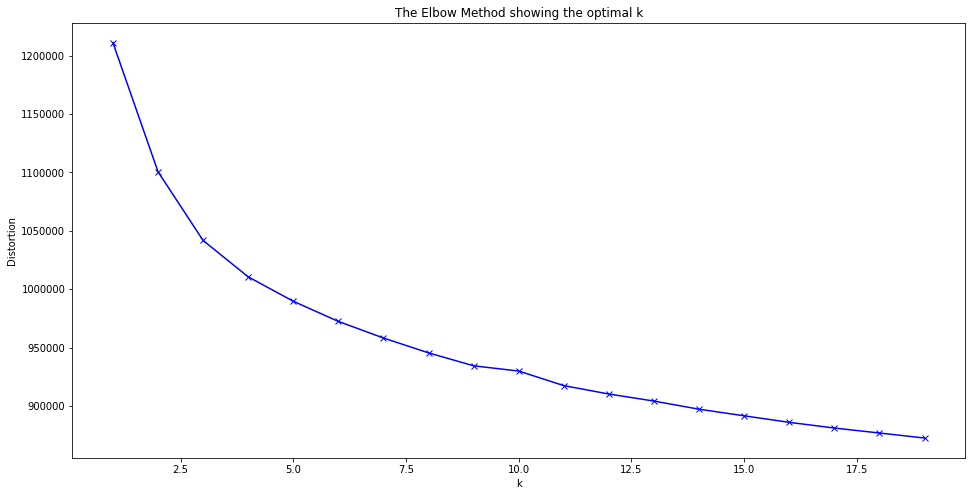

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

#we are using

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_final)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [70]:
# so the best number of clusters is 5
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(df_final)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
df_final["k_means"].unique() 

array([4, 0, 3, 2, 1])

In [77]:
df_final

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57,k_means
0,2.216055,1.996385,-0.227366,1.110026,0.314709,-0.566863,-0.320732,-0.326196,0.664306,1.306621,...,-0.246014,0.127142,0.768119,-0.132851,-0.736603,-0.123364,-0.844794,-0.423781,0.195495,4
1,-1.724909,0.204926,1.350359,-1.667106,-0.632619,-0.273760,0.336609,-0.090146,0.563675,-0.420167,...,0.336042,-0.644772,0.239583,0.263036,-0.348790,-0.387383,0.330218,-0.707295,0.210041,0
2,1.378529,0.137812,-0.106971,-1.737831,0.220038,0.234935,0.059056,1.634898,-0.195267,-0.746419,...,-0.989409,0.224567,-0.259518,-0.413831,0.282456,0.410690,-0.193707,0.565915,0.010457,3
3,0.362861,-1.166034,0.146817,-0.705996,0.801043,0.146933,0.286676,0.024181,-0.330594,-0.738936,...,0.117972,0.042615,0.308663,-0.099428,0.339804,-0.047904,-0.226390,-0.184308,-0.200860,3
4,0.760717,-0.291888,-0.340785,-0.288959,1.450005,0.238143,0.012762,-0.093153,1.095529,-0.328544,...,0.301954,-0.315399,-0.163243,0.344282,-0.049179,-0.102269,-0.171370,0.158237,-0.093001,3
5,-1.448754,0.655378,1.441114,-0.497224,-0.246323,0.259514,-0.126248,-0.608170,-0.085765,0.769280,...,-0.419838,-0.076151,-0.275516,0.401734,0.432518,0.083772,-0.409474,0.264877,0.732690,2
6,1.496187,0.909409,-0.005072,0.521138,0.097186,-1.274872,0.577138,0.003531,-1.564741,-0.431376,...,-0.071180,0.445697,-0.533630,0.175533,0.180204,-0.057098,-0.506834,0.332410,-0.278296,4
7,-0.039878,1.873688,-1.478274,1.388707,0.338163,0.518948,-0.476449,1.827255,1.056638,0.469325,...,0.025546,-0.217356,-0.669738,-0.237967,0.555437,0.360106,-0.691749,0.117966,-0.425284,4
8,0.483920,0.487368,0.600972,1.096402,0.452381,1.396492,-0.665159,0.530511,-0.097746,-0.079305,...,0.093491,0.467772,0.867838,0.476557,0.282765,-0.013938,0.135720,0.053149,0.005336,2
9,0.498981,-0.271042,1.652168,-0.897709,-0.021269,0.157026,-1.015297,0.455307,-1.505014,0.008484,...,0.042285,-0.821785,-0.155705,0.259462,-0.292084,0.272315,0.065880,0.169586,0.071175,3


In [78]:
df_final["customer_belong_column"]=  customer_belong_column
df_final

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57,k_means,customer_belong_column
0,2.216055,1.996385,-0.227366,1.110026,0.314709,-0.566863,-0.320732,-0.326196,0.664306,1.306621,...,0.127142,0.768119,-0.132851,-0.736603,-0.123364,-0.844794,-0.423781,0.195495,4,1
1,-1.724909,0.204926,1.350359,-1.667106,-0.632619,-0.273760,0.336609,-0.090146,0.563675,-0.420167,...,-0.644772,0.239583,0.263036,-0.348790,-0.387383,0.330218,-0.707295,0.210041,0,1
2,1.378529,0.137812,-0.106971,-1.737831,0.220038,0.234935,0.059056,1.634898,-0.195267,-0.746419,...,0.224567,-0.259518,-0.413831,0.282456,0.410690,-0.193707,0.565915,0.010457,3,1
3,0.362861,-1.166034,0.146817,-0.705996,0.801043,0.146933,0.286676,0.024181,-0.330594,-0.738936,...,0.042615,0.308663,-0.099428,0.339804,-0.047904,-0.226390,-0.184308,-0.200860,3,1
4,0.760717,-0.291888,-0.340785,-0.288959,1.450005,0.238143,0.012762,-0.093153,1.095529,-0.328544,...,-0.315399,-0.163243,0.344282,-0.049179,-0.102269,-0.171370,0.158237,-0.093001,3,1
5,-1.448754,0.655378,1.441114,-0.497224,-0.246323,0.259514,-0.126248,-0.608170,-0.085765,0.769280,...,-0.076151,-0.275516,0.401734,0.432518,0.083772,-0.409474,0.264877,0.732690,2,1
6,1.496187,0.909409,-0.005072,0.521138,0.097186,-1.274872,0.577138,0.003531,-1.564741,-0.431376,...,0.445697,-0.533630,0.175533,0.180204,-0.057098,-0.506834,0.332410,-0.278296,4,1
7,-0.039878,1.873688,-1.478274,1.388707,0.338163,0.518948,-0.476449,1.827255,1.056638,0.469325,...,-0.217356,-0.669738,-0.237967,0.555437,0.360106,-0.691749,0.117966,-0.425284,4,1
8,0.483920,0.487368,0.600972,1.096402,0.452381,1.396492,-0.665159,0.530511,-0.097746,-0.079305,...,0.467772,0.867838,0.476557,0.282765,-0.013938,0.135720,0.053149,0.005336,2,1
9,0.498981,-0.271042,1.652168,-0.897709,-0.021269,0.157026,-1.015297,0.455307,-1.505014,0.008484,...,-0.821785,-0.155705,0.259462,-0.292084,0.272315,0.065880,0.169586,0.071175,3,1


In [88]:
# How many entries of each clusters are customers or not:

df_final
customers_cluster_0 = len(df_final[(df_final['customer_belong_column'] == 1) & (df_final['k_means'] == 0)])
customers_cluster_0

#customers_cluster_1 = len(df_final[(df_final['customer_belong_column'] == 1) & (df_final['k_means'] == 1)])
#customers_cluster_1

#customers_cluster_2 = len(df_final[(df_final['customer_belong_column'] == 1) & (df_final['k_means'] == 2)])
#customers_cluster_2


7968

In [96]:
customers_in_clusters = {}
for i in range(0,5):
    customers_in_clusters["customers_cluster_"+ str(i)] = len(df_final[(df_final['customer_belong_column'] == 1) & (df_final['k_means'] == i)])
    
print("customers_dict:",customers_in_clusters)

azdias_in_clusters = {}
for i in range(0,5):
    azdias_in_clusters["customers_cluster_"+ str(i)] = len(df_final[(df_final['customer_belong_column'] == 0) & (df_final['k_means'] == i)])
    
print("azdias_dict", azdias_in_clusters)

customers_in_clusters


customers_dict: {'customers_cluster_0': 7968, 'customers_cluster_1': 7364, 'customers_cluster_2': 6351, 'customers_cluster_3': 6103, 'customers_cluster_4': 6413}
azdias_dict {'customers_cluster_0': 7440, 'customers_cluster_1': 7552, 'customers_cluster_2': 4521, 'customers_cluster_3': 5661, 'customers_cluster_4': 6829}


{'customers_cluster_0': 7968,
 'customers_cluster_1': 7364,
 'customers_cluster_2': 6351,
 'customers_cluster_3': 6103,
 'customers_cluster_4': 6413}

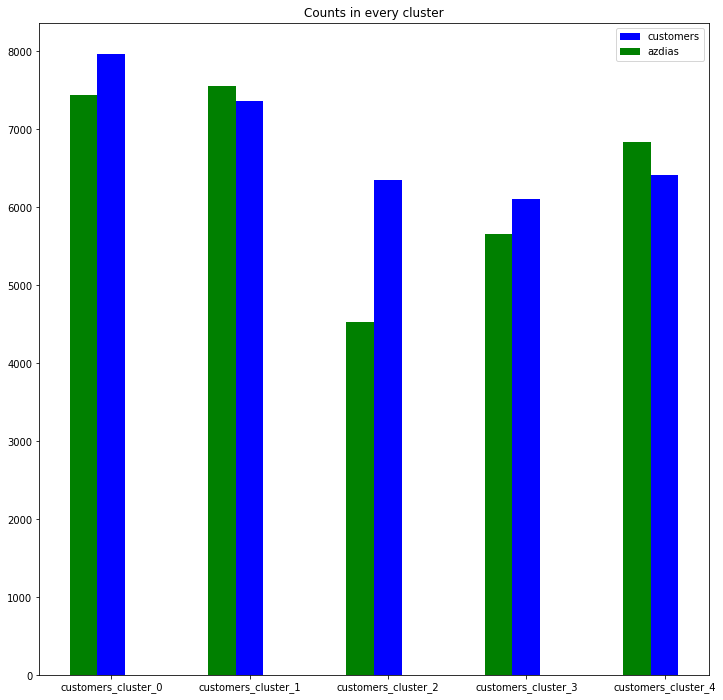

In [105]:
# plot counts of every cluster:
customers_in_clusters
azdias_in_clusters

X = np.arange(len(customers_in_clusters))
fig = plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.bar(X, customers_in_clusters.values(), width=0.2, color='b', align='center')
ax.bar(X-0.2, azdias_in_clusters.values(), width=0.2, color='g', align='center')
ax.legend(('customers','azdias'))
plt.xticks(X, customers_in_clusters.keys())
plt.title("Counts in every cluster", fontsize=12)
plt.show()

### The highest probability of general population to become customers:


As shown from the above the highest counts of the general population clusters that are also customers belong to the clusters 0 and cluster 1. 

Correlation between the clusters 1 for each the customers and general poppulation to view the similarities and differences:

Dimension25  Dimension2     0.091947
Dimension2   Dimension25    0.091947
Dimension13  Dimension4     0.091987
Dimension4   Dimension13    0.091987
Dimension36  Dimension2     0.096777
Dimension2   Dimension36    0.096777
Dimension18  Dimension23    0.101612
Dimension23  Dimension18    0.101612
Dimension7   Dimension3     0.103558
Dimension3   Dimension7     0.103558
Dimension10  Dimension3     0.107406
Dimension3   Dimension10    0.107406
Dimension28  Dimension33    0.108477
Dimension33  Dimension28    0.108477
Dimension4   Dimension2     0.112604
Dimension2   Dimension4     0.112604
Dimension7   Dimension15    0.114934
Dimension15  Dimension7     0.114934
Dimension44  Dimension45    0.117294
Dimension45  Dimension44    0.117294
Dimension13  Dimension11    0.124275
Dimension11  Dimension13    0.124275
Dimension1   Dimension16    0.124891
Dimension16  Dimension1     0.124891
Dimension3   Dimension23    0.127713
Dimension23  Dimension3     0.127713
Dimension3   Dimension14    0.130583
D

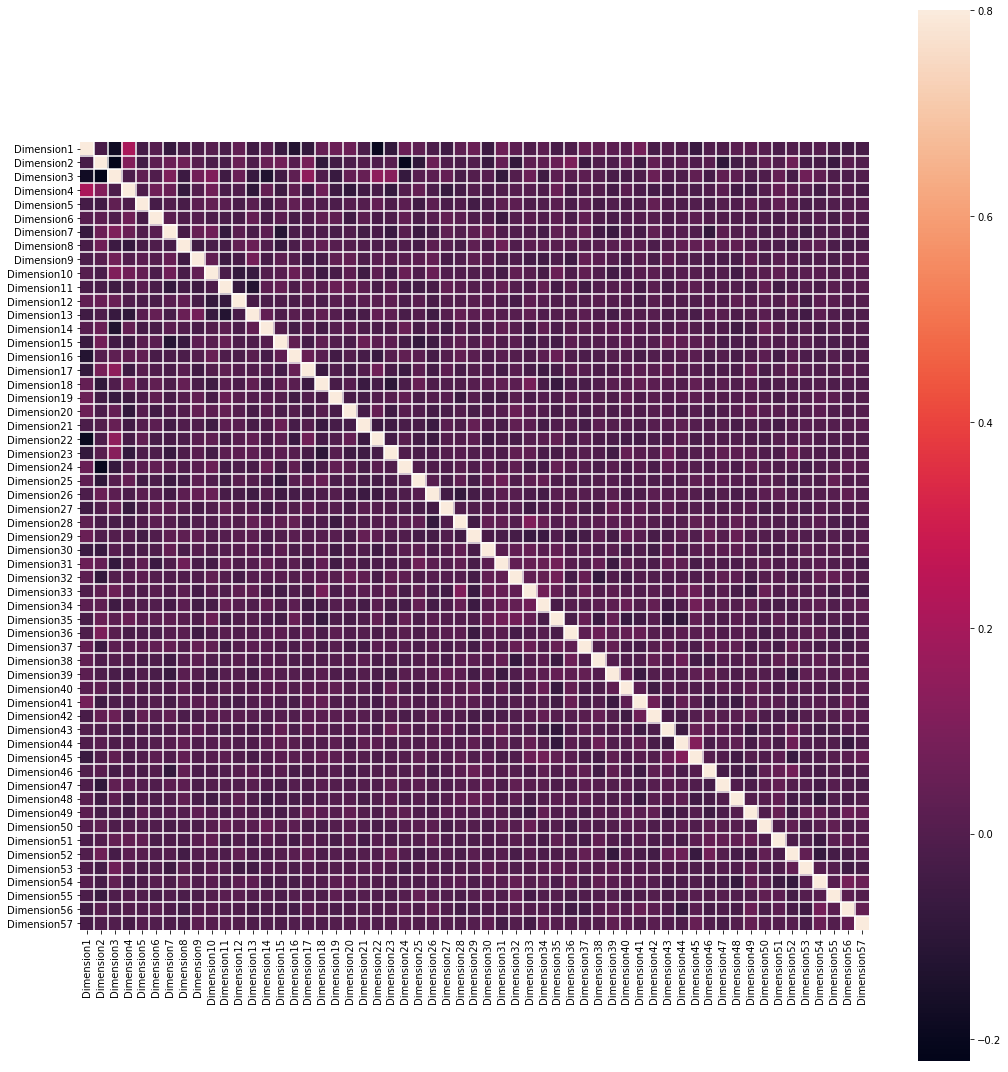

In [166]:
customers_cluster_1= df_final[(df_final['customer_belong_column'] == 1) & (df_final['k_means'] == 1)]
azdias_cluster_1= df_final[(df_final['customer_belong_column'] == 0) & (df_final['k_means'] == 1)]

#azdiss_cluster_1=



customers_cluster_1 = customers_cluster_1.drop(['customer_belong_column'], axis = 1)
customers_cluster_1 = customers_cluster_1.drop(['k_means'], axis = 1)

customers_cluster_1

# Use the weights for the pca components

azdias_cluster_1 = azdias_cluster_1.drop(['customer_belong_column'], axis = 1)
azdias_cluster_1 = azdias_cluster_1.drop(['k_means'], axis = 1)

azdias_cluster_1

# seaborn correlation heatmap:
X= customers_cluster_1
Y= azdias_cluster_1

frames = [X,Y]

catted = pd.concat(frames)
corrmat = catted.corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, vmax=.8, square=True)
sources = corrmat.columns.get_level_values(0)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        ax.axhline(len(sources) - i, c="w")
        ax.axvline(i, c="w")
f.tight_layout()

corrmat

#sort correlation values:
sorted_corr = corrmat.abs()

s = sorted_corr.unstack()
so= s.sort_values(kind="quicksort")

so.count()
#3249
# highest correlations:
so[3150: 3210]
# so
# dimensions 2,3 are the most highly correlated
so[0:100]


# Find highest weights for dimensions 2,3

- Cluster 1 for the general popppulation and the customers dataset have very similar features to the principal components 2 and 3 and the least similarity for principal component features represented by dimension 54.   

## The dataset to be preprocessed and used for training:

### 1.2 Data preprocessing

In [4]:
# will work on the train dataset

mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [6]:
df_mailout_train = pd.DataFrame(mailout_train)

In [7]:
df_mailout_train.shape

(42962, 367)

In [8]:
df_mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


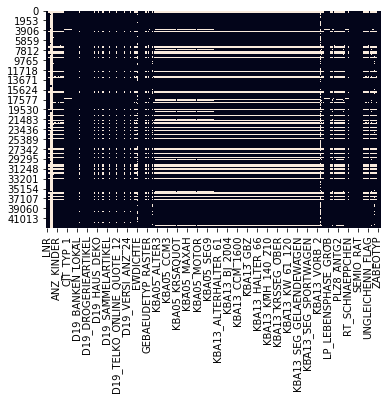

In [9]:
sns.heatmap(df_mailout_train.isnull(), cbar=False)

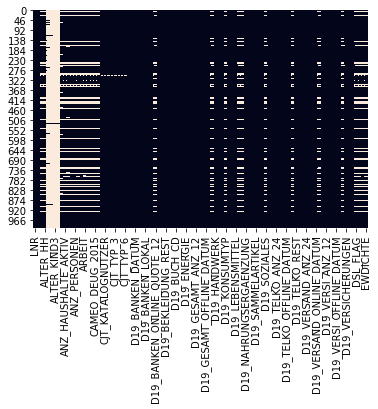

In [10]:
sns.heatmap(df_mailout_train.iloc[:1000,:100].isnull(), cbar=False)

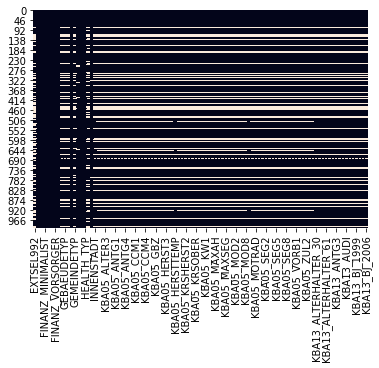

In [11]:
sns.heatmap(df_mailout_train.iloc[:1000,100:200].isnull(), cbar=False)

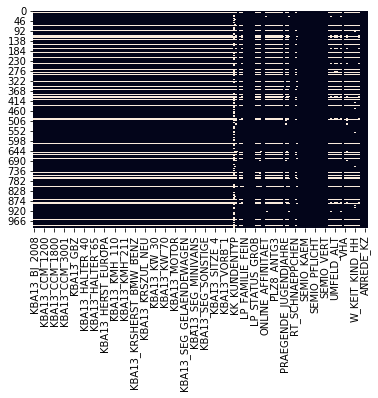

In [12]:
sns.heatmap(df_mailout_train.iloc[:1000,200:].isnull(), cbar=False)

In [13]:
# drop the rows where they have more than 10 missing values
print(df_mailout_train.shape)
# accepts minimum non-Na values in rows, here atleast 10 values are Nan
df_mailout_train_droppedna = df_mailout_train.dropna(thresh=357)
df_mailout_train_droppedna.shape

(42962, 367)


(32920, 367)

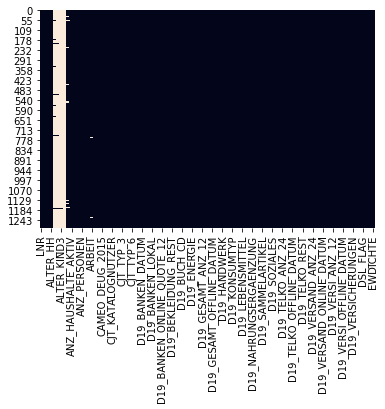

In [14]:
sns.heatmap(df_mailout_train_droppedna.iloc[:1000,:100].isnull(), cbar=False)

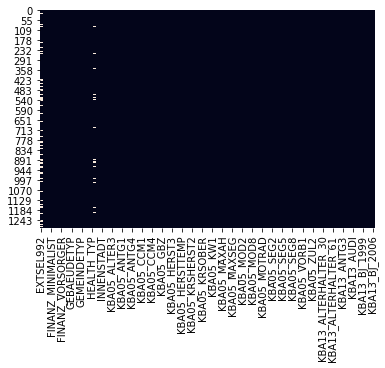

In [15]:
sns.heatmap(df_mailout_train_droppedna.iloc[:1000,100:200].isnull(), cbar=False)

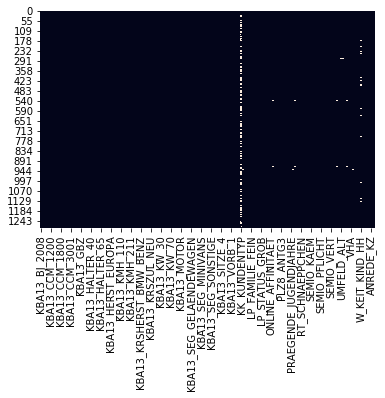

In [16]:
sns.heatmap(df_mailout_train_droppedna.iloc[:1000,200:].isnull(), cbar=False)

In [17]:
# drop the rows that have above 400 missing values

# drop the columns where they have more than 400 missing values in all rows per column
print(df_mailout_train_droppedna.shape)
# accepts minimum non-Na values in rows, here atleast 400 values are Nan: 32920-5920= 27000
df_mailout_train_droppedna_complete = df_mailout_train_droppedna.dropna(axis= 1, thresh=27000)
print('final shape:',df_mailout_train_droppedna_complete.shape)
# 6 columns are dropped that had 5920 missing rows each



(32920, 367)
final shape: (32920, 361)


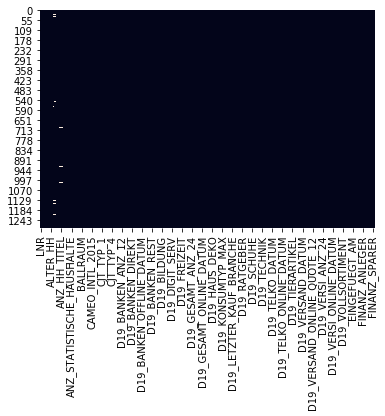

In [18]:
sns.heatmap(df_mailout_train_droppedna_complete.iloc[:1000,:100].isnull(), cbar=False)

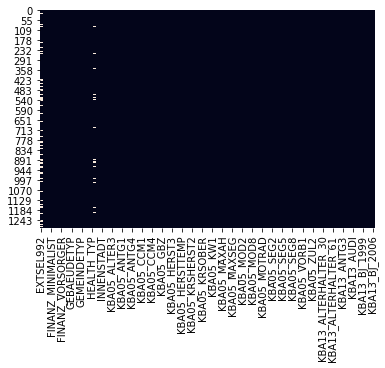

In [19]:
sns.heatmap(df_mailout_train_droppedna.iloc[:1000,100:200].isnull(), cbar=False)

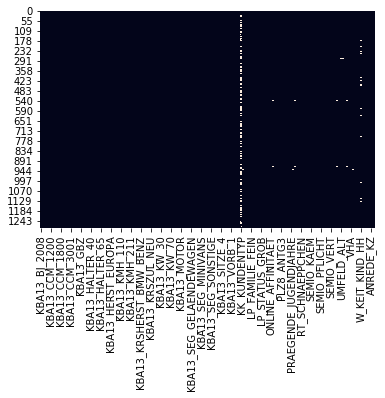

In [20]:
sns.heatmap(df_mailout_train_droppedna.iloc[:1000,200:].isnull(), cbar=False)

In [21]:
df_mailout_train_droppedna_complete.iloc[:,250:300].columns

Index(['KBA13_KRSZUL_NEU', 'KBA13_KW_0_60', 'KBA13_KW_110', 'KBA13_KW_120',
       'KBA13_KW_121', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50',
       'KBA13_KW_60', 'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80',
       'KBA13_KW_90', 'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR',
       'KBA13_NISSAN', 'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT',
       'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS',
       'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_KOMPAKTKLASSE',
       'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE',
       'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE',
       'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_UTILITIES',
       'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE', 'KBA13_SITZE_4',
       'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA', 'KBA13_VORB_0',
       'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2', 'KBA13_VORB_3',
       'KBA13_VW', 'KKK', 'KOMBIALTER', 'KONSUMNAEHE', 'KONSUMZELLE',
       

In [22]:
df_mailout_train_droppedna_complete.iloc[: ,250:300].isnull().sum()

KBA13_KRSZUL_NEU                 0
KBA13_KW_0_60                    0
KBA13_KW_110                     0
KBA13_KW_120                     0
KBA13_KW_121                     0
KBA13_KW_30                      0
KBA13_KW_40                      0
KBA13_KW_50                      0
KBA13_KW_60                      0
KBA13_KW_61_120                  0
KBA13_KW_70                      0
KBA13_KW_80                      0
KBA13_KW_90                      0
KBA13_MAZDA                      0
KBA13_MERCEDES                   0
KBA13_MOTOR                      0
KBA13_NISSAN                     0
KBA13_OPEL                       0
KBA13_PEUGEOT                    0
KBA13_RENAULT                    0
KBA13_SEG_GELAENDEWAGEN          0
KBA13_SEG_GROSSRAUMVANS          0
KBA13_SEG_KLEINST                0
KBA13_SEG_KLEINWAGEN             0
KBA13_SEG_KOMPAKTKLASSE          0
KBA13_SEG_MINIVANS               0
KBA13_SEG_MINIWAGEN              0
KBA13_SEG_MITTELKLASSE           0
KBA13_SEG_OBEREMITTE

In [23]:
df_mailout_train_droppedna_complete["KKK"].unique()

array([  3.,   2.,   1.,   0.,   4.,  nan])

In [24]:
# method to replace with median
def replace_Nan_with_median (df, column_list):
    
    for i in column_list:
        #print('i:::',column_name)
        median = df[i].median()
        df[i] =  df[i].fillna(median)
        #return new_df[column_name]
    print(df)
    return df
    

In [25]:
int_float_columns = [key for key in dict(df_mailout_train_droppedna_complete.dtypes) if dict(df_mailout_train_droppedna_complete.dtypes)[key] in ['int64', 'float64']]

categorical_columns = [key for key in dict(df_mailout_train_droppedna_complete.dtypes) if dict(df_mailout_train_droppedna_complete.dtypes)[key] in ['object']]

categorical_columns


['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [26]:
#print(df_mailout_train[int_float_columns].isnull().sum())

replace_Nan_with_median(df_mailout_train_droppedna_complete, int_float_columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0       1763         2         1.0       8.0                   8.0   
1       1771         1         4.0      13.0                  13.0   
2       1776         1         1.0       9.0                   7.0   
3       1460         2         1.0       6.0                   6.0   
4       1783         2         1.0       9.0                   9.0   
5       1789         3         1.0      12.0                  12.0   
6       1795         1         1.0       8.0                   8.0   
7       1493         2         1.0      13.0                  13.0   
11      2512         2         1.0       8.0                   8.0   
12      2513         1         1.0      15.0                   8.0   
13      2515         1         1.0      20.0                  12.0   
14      2198        -1         1.0      21.0                  16.0   
15      2528         1         1.0      11.0                  11.0   
17      2554        

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,0.0,0.0,0.0,1.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,8.0,2.0,0.0,0.0,1.0,1.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
11,2512,2,1.0,8.0,8.0,2.0,0.0,0.0,2.0,2.0,...,7.0,8.0,5.0,6.0,9.0,7.0,3,0,1,4
12,2513,1,1.0,15.0,8.0,1.0,0.0,0.0,3.0,1.0,...,1.0,1.0,1.0,3.0,9.0,4.0,3,0,2,4


In [27]:
print(df_mailout_train_droppedna_complete[int_float_columns].isnull().sum())


LNR                           0
AGER_TYP                      0
AKT_DAT_KL                    0
ALTER_HH                      0
ALTERSKATEGORIE_FEIN          0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_ONLINE_QUOTE_12    0
                             ..
SEMIO_KU

In [28]:
categorical_columns = [key for key in dict(df_mailout_train_droppedna_complete.dtypes) if dict(df_mailout_train_droppedna_complete.dtypes)[key] in ['object']]


In [29]:
df_mailout_train_droppedna_complete[categorical_columns[2]].unique()

array([34.0, 32.0, 14.0, 41.0, 24.0, 33.0, 25.0, 31.0, 22.0, 43.0, 13.0,
       55.0, 23.0, 54.0, 51.0, 45.0, 12.0, 44.0, 35.0, 15.0, 52.0, nan,
       '23', '44', '14', '55', '51', '45', '43', '22', '54', '24', '25',
       '13', '12', '35', '33', '41', '15', '52', '32', '34', '31', 'XX'], dtype=object)

In [30]:
# Replace categorical missing values with most_frequent of column: mode
# not working

def replace_missing_categorical_data(df, categorical_columns_names_list):
    
    for i in categorical_columns_names_list:
        mode = df[i].mode()
        df[i].fillna(df[i][0])
    return df

In [31]:
replace_missing_categorical_data(df_mailout_train_droppedna_complete, categorical_columns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,0.0,0.0,0.0,1.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,8.0,2.0,0.0,0.0,1.0,1.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
11,2512,2,1.0,8.0,8.0,2.0,0.0,0.0,2.0,2.0,...,7.0,8.0,5.0,6.0,9.0,7.0,3,0,1,4
12,2513,1,1.0,15.0,8.0,1.0,0.0,0.0,3.0,1.0,...,1.0,1.0,1.0,3.0,9.0,4.0,3,0,2,4


In [32]:
categorical_columns

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [33]:
df = df_mailout_train_droppedna_complete



In [34]:
df[categorical_columns[0]].unique()
df['CAMEO_DEU_2015'].unique()

df['CAMEO_DEU_2015'].fillna(df['CAMEO_DEU_2015'].mode()[0], inplace=True)

df['CAMEO_DEUG_2015'].fillna(df['CAMEO_DEUG_2015'].mode()[0], inplace=True)

df['CAMEO_INTL_2015'].fillna(df['CAMEO_INTL_2015'].mode()[0], inplace=True)
df[categorical_columns[2]].unique()




/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


array([34.0, 32.0, 14.0, 41.0, 24.0, 33.0, 25.0, 31.0, 22.0, 43.0, 13.0,
       55.0, 23.0, 54.0, 51.0, 45.0, 12.0, 44.0, 35.0, 15.0, 52.0, '23',
       '44', '14', '55', '51', '45', '43', '22', '54', '24', '25', '13',
       '12', '35', '33', '41', '15', '52', '32', '34', '31', 'XX'], dtype=object)

In [35]:
# create dummies variables for categorical variables
for i in categorical_columns:
    df = pd.get_dummies(df, columns=[i])
    


In [36]:
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 32920 entries, 0 to 42961
Columns: 1774 entries, LNR to OST_WEST_KZ_W
dtypes: float64(261), int64(94), uint8(1419)
memory usage: 135.2 MB


### Detect and remove outliers:

Using the IQR method

In [37]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)




LNR                                  43864.25
AGER_TYP                                 3.00
AKT_DAT_KL                               0.00
ALTER_HH                                 7.00
ALTERSKATEGORIE_FEIN                     4.00
ANZ_HAUSHALTE_AKTIV                      6.00
ANZ_HH_TITEL                             0.00
ANZ_KINDER                               0.00
ANZ_PERSONEN                             2.00
ANZ_STATISTISCHE_HAUSHALTE               5.00
ANZ_TITEL                                0.00
ARBEIT                                   2.00
BALLRAUM                                 4.00
CJT_GESAMTTYP                            2.00
CJT_KATALOGNUTZER                        2.00
CJT_TYP_1                                2.00
CJT_TYP_2                                1.00
CJT_TYP_3                                1.00
CJT_TYP_4                                1.00
CJT_TYP_5                                1.00
CJT_TYP_6                                1.00
D19_BANKEN_ANZ_12                 

In [38]:
# outliers are the true values
print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))

         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0      False     False       False     False                 False   
1      False     False       False     False                 False   
2      False     False       False     False                 False   
3      False     False       False     False                 False   
4      False     False       False     False                 False   
5      False     False       False     False                 False   
6      False     False       False     False                 False   
7      False     False       False     False                 False   
11     False     False       False     False                 False   
12     False     False       False     False                 False   
13     False     False       False     False                 False   
14     False     False       False     False                 False   
15     False     False       False     False                 False   
17     False     Fal

TypeError: Could not compare [None] with block values

In [39]:
# df_out is a df with outliers removed by including all values that are "not" outliers
df_out = df[~(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))]

In [40]:
df_out.shape

(32920, 1774)

In [41]:
df_out.isnull().sum()



LNR                                     0
AGER_TYP                                0
AKT_DAT_KL                              0
ALTER_HH                                0
ALTERSKATEGORIE_FEIN                 3167
ANZ_HAUSHALTE_AKTIV                     0
ANZ_HH_TITEL                            0
ANZ_KINDER                              0
ANZ_PERSONEN                            0
ANZ_STATISTISCHE_HAUSHALTE              0
ANZ_TITEL                               0
ARBEIT                                  0
BALLRAUM                                0
CJT_GESAMTTYP                           0
CJT_KATALOGNUTZER                       0
CJT_TYP_1                               0
CJT_TYP_2                               0
CJT_TYP_3                            2179
CJT_TYP_4                            3646
CJT_TYP_5                            2019
CJT_TYP_6                            2875
D19_BANKEN_ANZ_12                       0
D19_BANKEN_ANZ_24                       0
D19_BANKEN_DATUM                  

In [42]:
print(df_out < (Q1 - 1.5 * IQR)) |(df_out > (Q3 + 1.5 * IQR))

         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0      False     False       False     False                 False   
1      False     False       False     False                 False   
2      False     False       False     False                 False   
3      False     False       False     False                 False   
4      False     False       False     False                 False   
5      False     False       False     False                 False   
6      False     False       False     False                 False   
7      False     False       False     False                 False   
11     False     False       False     False                 False   
12     False     False       False     False                 False   
13     False     False       False     False                 False   
14     False     False       False     False                 False   
15     False     False       False     False                 False   
17     False     Fal

TypeError: Could not compare [None] with block values

In [45]:
int_float_columns = [key for key in dict(df_out.dtypes) if dict(df_out.dtypes)[key] in ['int64', 'float64', 'uint8']]

replace_Nan_with_median(df_out, int_float_columns)

df_out.info()

         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0       1763         2         1.0       8.0                   8.0   
1       1771         1         4.0      13.0                  13.0   
2       1776         1         1.0       9.0                   7.0   
3       1460         2         1.0       6.0                   6.0   
4       1783         2         1.0       9.0                   9.0   
5       1789         3         1.0      12.0                  12.0   
6       1795         1         1.0       8.0                   8.0   
7       1493         2         1.0      13.0                  13.0   
11      2512         2         1.0       8.0                   8.0   
12      2513         1         1.0      15.0                   8.0   
13      2515         1         1.0      20.0                  12.0   
14      2198        -1         1.0      21.0                  16.0   
15      2528         1         1.0      11.0                  11.0   
17      2554        

In [46]:
df_out.isnull().sum()

df_out["RESPONSE"].unique()

array([0, 1])

In [47]:
# rename the modified dataframe as df
df = df_out



## Feature scaling providing a range from 0 to 1

In [48]:
# print unique values for a number of columns
for i in range(1773,1774):
    u = pd.unique(df.iloc[i])
print (u)

df.iloc[:,90:99]

df["RESPONSE"]

[  5.79520000e+04  -1.00000000e+00   2.00000000e+00   0.00000000e+00
   1.40000000e+01   1.00000000e+00   3.00000000e+00   6.00000000e+00
   4.00000000e+00   1.00000000e+01   5.00000000e+00   9.00000000e+00
   2.00500000e+03   8.00000000e+00   1.96200000e+03   2.20000000e+01
   7.00000000e+00   6.13000000e+02   1.90000000e+01   1.99700000e+03]


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
11       0
12       0
13       0
14       0
15       0
17       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
29       0
30       0
31       0
32       0
34       0
35       0
36       0
37       0
        ..
42931    0
42932    0
42933    0
42934    0
42935    1
42936    0
42937    0
42938    0
42939    0
42940    0
42941    0
42942    0
42943    0
42944    0
42945    0
42946    0
42947    0
42948    0
42949    0
42950    0
42951    0
42952    0
42953    0
42955    0
42956    0
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 32920, dtype: int64

In [49]:
from sklearn import preprocessing

#the response column. error is here as column names were removed


x = df.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=df.columns, index=df.index) 

df_scaled["RESPONSE"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
17       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
29       0.0
30       0.0
31       0.0
32       0.0
34       0.0
35       0.0
36       0.0
37       0.0
        ... 
42931    0.0
42932    0.0
42933    0.0
42934    0.0
42935    1.0
42936    0.0
42937    0.0
42938    0.0
42939    0.0
42940    0.0
42941    0.0
42942    0.0
42943    0.0
42944    0.0
42945    0.0
42946    0.0
42947    0.0
42948    0.0
42949    0.0
42950    0.0
42951    0.0
42952    0.0
42953    0.0
42955    0.0
42956    0.0
42957    0.0
42958    0.0
42959    0.0
42960    0.0
42961    0.0
Name: RESPONSE, Length: 32920, dtype: float64

In [50]:
# print unique values for a number of columns after feature scaling
for i in range(1773,1774):
    u = pd.unique(df_scaled.iloc[i])
print (u)

df_scaled.iloc[:,90:99]

df = df_scaled



[ 0.67542142  0.          0.125       0.52173913  0.00228311  0.08333333
  0.00271003  0.25        0.83333333  1.          0.5         1.
  0.85714286  0.28571429  0.42857143  0.14285714  0.57142857  0.71428571
  0.11111111  0.1         0.2         0.85714286  0.59375     0.75        1.
  0.97273178  0.28205128  0.85714286  0.6         0.33333333  0.66666667
  0.26652174  0.33333333  0.8         0.66666667  0.4         0.18181818
  0.475       0.41666667  0.88888889  0.38461538  0.55555556  0.53333333
  0.16666667]


### PCA principal component analysis for dimensionality reduction

In [51]:
#print(df["RESPONSE"])

df_without_response_col = df.drop(["RESPONSE"], axis=1)

#print(df_without_response_col["RESPONSE"])

response_series = pd.Series(df["RESPONSE"])

# response_series: variable containing the Series of the response column
response_series

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
17       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
29       0.0
30       0.0
31       0.0
32       0.0
34       0.0
35       0.0
36       0.0
37       0.0
        ... 
42931    0.0
42932    0.0
42933    0.0
42934    0.0
42935    1.0
42936    0.0
42937    0.0
42938    0.0
42939    0.0
42940    0.0
42941    0.0
42942    0.0
42943    0.0
42944    0.0
42945    0.0
42946    0.0
42947    0.0
42948    0.0
42949    0.0
42950    0.0
42951    0.0
42952    0.0
42953    0.0
42955    0.0
42956    0.0
42957    0.0
42958    0.0
42959    0.0
42960    0.0
42961    0.0
Name: RESPONSE, Length: 32920, dtype: float64

In [52]:
from sklearn.decomposition import PCA
# import visuals as vs

# Use 57 principal component to cover 60% of the data variance
pca = PCA(n_components = 57)

pca.fit(df_without_response_col)

print(pca.explained_variance_ratio_)

print("Total variance covered: ",pca.explained_variance_ratio_.sum())

# choose rows 1,2,3, all columns:
#log_samples = df_without_response_col.loc[[1, 2, 3], :]

#pca_samples = pca.transform(log_samples)

#pca_results = vs.pca_results(pca_samples, pca)

[ 0.090985    0.04950686  0.04454779  0.02528635  0.02384562  0.02018384
  0.01715056  0.01538709  0.01474914  0.01335177  0.01268415  0.01231207
  0.01125662  0.01072887  0.0091116   0.00901125  0.00867474  0.00832337
  0.00825     0.00789564  0.00760425  0.0072201   0.0070516   0.00689685
  0.00676538  0.00671583  0.00646025  0.00628772  0.00617309  0.00610761
  0.00591759  0.00557227  0.00555701  0.00546648  0.00542902  0.00532841
  0.00528005  0.00520268  0.00510728  0.00500764  0.00482401  0.00472116
  0.00460962  0.00450452  0.00447335  0.00443447  0.0044119   0.00432883
  0.00422389  0.00415824  0.0041089   0.00404634  0.00399729  0.00395649
  0.00387362  0.00385911  0.00379124]
Total variance covered:  0.606716426172


In [53]:
pca =PCA(n_components = 57)

pca.fit(df_without_response_col)

reduced_data = pca.transform(df_without_response_col)

# pca_samples = pca.transform(log_samples)

# in range function does not include the finishing element 58, so it creates 57 columns
col_list = ['Dimension' + str(x) for x in range(1,58)]
col_list

reduced_data = pd.DataFrame(data = reduced_data, columns = col_list)

reduced_data

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension48,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57
0,2.946906,0.290097,0.484407,-0.520574,-0.045061,-0.117177,0.564521,-0.344182,-0.562265,0.340900,...,-0.547949,-0.220733,0.228454,-0.093273,0.069343,0.398117,-0.625688,-0.267124,0.150147,0.126431
1,-1.779951,-0.671727,-0.691490,-1.077157,0.300680,-0.012778,0.594767,-0.217034,-0.069372,-0.105799,...,0.512790,0.140488,-0.155805,0.289822,0.141902,-0.228551,-0.231880,0.062136,0.118497,-0.503632
2,-0.144664,-0.886764,-0.233751,1.689795,-1.650137,0.629960,-0.386908,0.611224,0.900297,0.251813,...,-0.722620,0.119409,0.731045,0.229093,-0.136876,-0.187499,-0.371550,0.019490,0.292505,-0.332353
3,0.925855,-0.858063,3.219878,-0.819796,-0.849687,-0.223074,-0.072212,-0.587519,0.499872,-0.278695,...,-0.190268,-0.668304,0.324945,-0.173602,-0.481879,0.191141,-0.197021,-0.405052,-0.260815,-0.117333
4,1.201335,-0.055323,1.083938,1.280470,-0.871347,1.096959,0.846701,0.604581,-0.811526,-0.043813,...,0.504344,0.774421,0.126118,0.345419,0.189259,0.670728,0.097878,-0.519880,0.452004,-0.603345
5,2.037359,3.221023,-0.259839,-0.974064,0.853401,-1.304754,0.792782,-0.314020,0.248537,0.374387,...,0.226396,0.513324,-0.264645,0.280449,0.200935,0.530055,0.421793,0.012594,0.646645,-0.182141
6,-0.409796,-1.770970,-0.195802,-0.655758,-0.876249,0.294210,-0.917308,0.343393,-0.663318,0.136523,...,0.014362,-0.414876,-0.220426,0.329349,0.561583,0.025167,-0.014660,-0.252100,0.440536,-0.156418
7,-1.143347,-1.178098,-0.177188,-0.651452,0.188217,0.315779,0.854155,-1.087968,-0.444518,-0.213236,...,0.235734,-0.330402,-0.317900,-0.173996,0.374648,-0.661488,-0.103322,0.271590,0.069112,-0.261045
8,-0.984897,-1.683185,-1.539330,0.515810,-0.277907,-0.401824,1.311337,-0.918774,0.292390,-0.253872,...,0.008760,0.738821,0.134665,0.098758,0.217399,0.421077,-0.252262,0.017979,-0.697709,-0.043153
9,-2.158750,0.792967,-0.189338,-0.504067,-0.629146,-0.440924,-0.023158,0.233317,-1.055935,0.228678,...,0.258624,-0.411772,-0.253284,0.484851,-0.025546,0.151010,-0.104140,-0.167161,0.071990,-0.069564


## Splitting the training dataset data into train and test


In [54]:
# to be tested
from sklearn.model_selection import train_test_split

# Is the DataFrame produced from the PCA Analysis and y consists of the labels, the response column
X= reduced_data
y= response_series

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)




## Part 2: Supervised Learning model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1: AdaBoost ensemble model 

In [55]:
#from sklearn.ensemble import AdaBoostClassifier

#clf = AdaBoostClassifier(n_estimators=100, random_state=0)

#clf.fit(X_train, y_train)

#clf.feature_importances_

# The base estimator is DecisionTreeClassifier(max_depth=1)
#clf.base_estimator_

#clf.predict(X_test)

#clf.score(X_test, y_test)

0.98821796759941094

### Adaboost supervised model with Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {'criterion':['gini', 'entropy'],
              'max_depth':[1,2,3,4,5],
              'min_samples_split':[2,4,6,8] }

decisiontree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator = decisiontree)

clf = GridSearchCV(ABC, tuned_parameters)

clf.fit(X_train, y_train)

print(clf.best_params_)

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

### 2.2: Using Cross validation to evaluate the model performance

In [56]:
from sklearn.cross_validation import cross_val_score

# will use the default scorer
# clf is the creeated supervised learning model, X: the train dataset, y: the Response column (labels)
# cv is the number of k-fold for splitting the data into subsets
crossvalidation_scores = cross_val_score(clf, X, y, cv=10)

print(crossvalidation_scores)

print("Mean 10-Fold for the default scorer for each k-fold: {}".format(np.mean(crossvalidation_scores)))


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.986942    0.98663832  0.98724567  0.9872418   0.9872418   0.98693803
  0.98693803  0.98723792  0.98754178  0.98754178]
Mean 10-Fold for the default scorer for each k-fold: 0.9871507137147116


### 2.3: Datapreprocessing and PCA analysis for the test set

In [3]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [59]:
df_mailout_test = pd.DataFrame(mailout_test)
df_mailout_test.info()
df_mailout_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


(42833, 366)

In [60]:
# accepts minimum non-Na values in rows, here atleast 10 values are Nan
# based on the .shape and its columns
df_mailout_test_droppedna = df_mailout_test.dropna(thresh=356)
df_mailout_test_droppedna.shape

(32863, 366)

In [61]:
# accepts minimum non-Na values in rows, here atleast 400 values are Nan: 32863-5863= 27000
df_mailout_test_droppedna_complete = df_mailout_test_droppedna.dropna(axis= 1, thresh=27000)


In [74]:
# method to replace with median
def replace_Nan_with_median (df, column_list):
    
    for i in column_list:
        #print('i:::',column_name)
        median = df[i].median()
        df[i] =  df[i].fillna(median)
        #return new_df[column_name]
    print(df)
    return df

In [75]:
# create variables with column names list based on datatypes   
int_float_columns = [key for key in dict(df_mailout_test_droppedna_complete.dtypes) if dict(df_mailout_test_droppedna_complete.dtypes)[key] in ['int64', 'float64']]

categorical_columns = [key for key in dict(df_mailout_test_droppedna_complete.dtypes) if dict(df_mailout_test_droppedna_complete.dtypes)[key] in ['object']]

replace_Nan_with_median(df_mailout_test_droppedna_complete, int_float_columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0       1754         2         1.0       7.0                   6.0   
1       1770        -1         1.0       0.0                   0.0   
2       1465         2         9.0      16.0                  11.0   
3       1470        -1         7.0       0.0                   0.0   
4       1478         1         1.0      21.0                  13.0   
5       1782         2         1.0       7.0                   7.0   
6       1485         2         1.0      10.0                   9.0   
7       1519        -1         1.0      20.0                  15.0   
8       1835         1         1.0      19.0                  13.0   
9       1522         1         1.0       0.0                   9.0   
10      1539         0         1.0       0.0                  12.0   
11      1853         1         1.0       6.0                   6.0   
12      1856        -1         2.0      20.0                  19.0   
14      2182        

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,0.0,20.0,0.0,0.0,1.0,21.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,1782,2,1.0,7.0,7.0,66.0,0.0,0.0,1.0,59.0,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4
6,1485,2,1.0,10.0,9.0,1.0,0.0,0.0,2.0,1.0,...,2.0,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4
7,1519,-1,1.0,20.0,15.0,1.0,0.0,0.0,4.0,1.0,...,2.0,4.0,5.0,4.0,2.0,9.0,3.0,4,2,3
8,1835,1,1.0,19.0,13.0,2.0,0.0,0.0,4.0,2.0,...,1.0,1.0,1.0,1.0,4.0,9.0,7.0,1,2,3
9,1522,1,1.0,0.0,9.0,1.0,0.0,0.0,1.0,1.0,...,2.0,5.0,8.0,9.0,3.0,4.0,2.0,4,1,3


In [76]:
print(df_mailout_test_droppedna_complete[int_float_columns].isnull().sum())

LNR                           0
AGER_TYP                      0
AKT_DAT_KL                    0
ALTER_HH                      0
ALTERSKATEGORIE_FEIN          0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_ONLINE_QUOTE_12    0
                             ..
SEMIO_KR

In [77]:
# see unique values of a certain column
df_mailout_test_droppedna_complete[categorical_columns[0]].unique()

array(['2B', '5A', '7A', '9D', '4E', '6B', '2D', '1D', '7E', '4C', '1C',
       '4A', '5F', '6D', '3C', '9B', '6C', '8B', '3D', '5D', '1A', '3A',
       '7B', '2C', '8A', '6F', '2A', '5B', '6E', '5C', '8D', '4D', '8C',
       '9E', '7C', '9A', '6A', '9C', '1B', '3B', '7D', '1E', '4B', '5E',
       'XX'], dtype=object)

In [78]:
# renaming
df = df_mailout_test_droppedna_complete

In [79]:
# replace missing categorical data with mode

print(categorical_columns)

for i in categorical_columns:
    df[i].fillna(df[i].mode()[0], inplace=True)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [80]:
# see unique values of a certain column for confirmation:
df[categorical_columns[0]].unique()

array(['2B', '5A', '7A', '9D', '4E', '6B', '2D', '1D', '7E', '4C', '1C',
       '4A', '5F', '6D', '3C', '9B', '6C', '8B', '3D', '5D', '1A', '3A',
       '7B', '2C', '8A', '6F', '2A', '5B', '6E', '5C', '8D', '4D', '8C',
       '9E', '7C', '9A', '6A', '9C', '1B', '3B', '7D', '1E', '4B', '5E',
       'XX'], dtype=object)

In [81]:
# create dummies variables for categorical variables
for i in categorical_columns:
    df = pd.get_dummies(df, columns=[i])
    
# test    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32863 entries, 0 to 42832
Columns: 1764 entries, LNR to OST_WEST_KZ_W
dtypes: float64(261), int64(93), uint8(1410)
memory usage: 133.2 MB


#### Detect and remove outliers using IQR method

In [82]:
# Detect and remove outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

LNR                                  43612.5
AGER_TYP                                 3.0
AKT_DAT_KL                               0.0
ALTER_HH                                 7.0
ALTERSKATEGORIE_FEIN                     4.0
ANZ_HAUSHALTE_AKTIV                      6.0
ANZ_HH_TITEL                             0.0
ANZ_KINDER                               0.0
ANZ_PERSONEN                             2.0
ANZ_STATISTISCHE_HAUSHALTE               5.0
ANZ_TITEL                                0.0
ARBEIT                                   2.0
BALLRAUM                                 4.0
CJT_GESAMTTYP                            2.0
CJT_KATALOGNUTZER                        2.0
CJT_TYP_1                                2.0
CJT_TYP_2                                1.0
CJT_TYP_3                                1.0
CJT_TYP_4                                1.0
CJT_TYP_5                                1.0
CJT_TYP_6                                1.0
D19_BANKEN_ANZ_12                        0.0
D19_BANKEN

In [83]:
# outliers are the true values
print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))


         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0      False     False       False     False                 False   
1      False     False       False     False                  True   
2      False     False       False     False                 False   
3      False     False       False     False                  True   
4      False     False       False     False                 False   
5      False     False       False     False                 False   
6      False     False       False     False                 False   
7      False     False       False     False                 False   
8      False     False       False     False                 False   
9      False     False       False     False                 False   
10     False     False       False     False                 False   
11     False     False       False     False                 False   
12     False     False       False     False                 False   
14     False     Fal

TypeError: Could not compare [None] with block values

In [84]:
# df_out is a df with outliers removed by including all values that are "not" outliers
# notice the bracket which was an error I was getting
df_out = df[~(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))]

In [85]:
# check as outliers were replaced with nan values
df_out.isnull().sum()

LNR                                     0
AGER_TYP                                0
AKT_DAT_KL                              0
ALTER_HH                                0
ALTERSKATEGORIE_FEIN                 3273
ANZ_HAUSHALTE_AKTIV                     0
ANZ_HH_TITEL                            0
ANZ_KINDER                              0
ANZ_PERSONEN                            0
ANZ_STATISTISCHE_HAUSHALTE              0
ANZ_TITEL                               0
ARBEIT                                  0
BALLRAUM                                0
CJT_GESAMTTYP                           0
CJT_KATALOGNUTZER                       0
CJT_TYP_1                               0
CJT_TYP_2                               0
CJT_TYP_3                            2079
CJT_TYP_4                            3631
CJT_TYP_5                            1986
CJT_TYP_6                            2802
D19_BANKEN_ANZ_12                       0
D19_BANKEN_ANZ_24                       0
D19_BANKEN_DATUM                  

In [86]:
# all should be false
print(df_out < (Q1 - 1.5 * IQR)) |(df_out > (Q3 + 1.5 * IQR))

         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0      False     False       False     False                 False   
1      False     False       False     False                 False   
2      False     False       False     False                 False   
3      False     False       False     False                 False   
4      False     False       False     False                 False   
5      False     False       False     False                 False   
6      False     False       False     False                 False   
7      False     False       False     False                 False   
8      False     False       False     False                 False   
9      False     False       False     False                 False   
10     False     False       False     False                 False   
11     False     False       False     False                 False   
12     False     False       False     False                 False   
14     False     Fal

TypeError: Could not compare [None] with block values

In [87]:
# replace Nan values with median
int_float_columns = [key for key in dict(df_out.dtypes) if dict(df_out.dtypes)[key] in ['int64', 'float64', 'uint8']]

replace_Nan_with_median(df_out, int_float_columns)

         LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0       1754         2         1.0       7.0                   6.0   
1       1770        -1         1.0       0.0                  10.0   
2       1465         2         9.0      16.0                  11.0   
3       1470        -1         7.0       0.0                  10.0   
4       1478         1         1.0      21.0                  13.0   
5       1782         2         1.0       7.0                   7.0   
6       1485         2         1.0      10.0                   9.0   
7       1519        -1         1.0      20.0                  15.0   
8       1835         1         1.0      19.0                  13.0   
9       1522         1         1.0       0.0                   9.0   
10      1539         0         1.0       0.0                  12.0   
11      1853         1         1.0       6.0                   6.0   
12      1856        -1         2.0      20.0                  19.0   
14      2182        

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,EINGEFUEGT_AM_2005-02-25 00:00:00,EINGEFUEGT_AM_2005-03-10 00:00:00,EINGEFUEGT_AM_2005-03-16 00:00:00,EINGEFUEGT_AM_2005-03-31 00:00:00,EINGEFUEGT_AM_2005-04-08 00:00:00,EINGEFUEGT_AM_2005-04-12 00:00:00,EINGEFUEGT_AM_2005-04-15 00:00:00,EINGEFUEGT_AM_2005-05-09 00:00:00,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1754,2,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1.0
1,1770,-1,1.0,0.0,10.0,20.0,0.0,0.0,1.0,21.0,...,0,0,0,0,0,0,0,0,0,1.0
2,1465,2,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,1.0
3,1470,-1,7.0,0.0,10.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0
4,1478,1,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
5,1782,2,1.0,7.0,7.0,66.0,0.0,0.0,1.0,59.0,...,0,0,0,0,0,0,0,0,1,1.0
6,1485,2,1.0,10.0,9.0,1.0,0.0,0.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
7,1519,-1,1.0,20.0,15.0,1.0,0.0,0.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
8,1835,1,1.0,19.0,13.0,2.0,0.0,0.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,1.0
9,1522,1,1.0,0.0,9.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


In [88]:
# check
df_out.info()
df_out.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32863 entries, 0 to 42832
Columns: 1764 entries, LNR to OST_WEST_KZ_W
dtypes: float64(279), int64(76), uint8(1409)
memory usage: 133.4 MB


LNR                                  0
AGER_TYP                             0
AKT_DAT_KL                           0
ALTER_HH                             0
ALTERSKATEGORIE_FEIN                 0
ANZ_HAUSHALTE_AKTIV                  0
ANZ_HH_TITEL                         0
ANZ_KINDER                           0
ANZ_PERSONEN                         0
ANZ_STATISTISCHE_HAUSHALTE           0
ANZ_TITEL                            0
ARBEIT                               0
BALLRAUM                             0
CJT_GESAMTTYP                        0
CJT_KATALOGNUTZER                    0
CJT_TYP_1                            0
CJT_TYP_2                            0
CJT_TYP_3                            0
CJT_TYP_4                            0
CJT_TYP_5                            0
CJT_TYP_6                            0
D19_BANKEN_ANZ_12                    0
D19_BANKEN_ANZ_24                    0
D19_BANKEN_DATUM                     0
D19_BANKEN_DIREKT                    0
D19_BANKEN_GROSS         

In [89]:
# rename the modified dataframe as df
df = df_out

### Feature Scaling providing a range from 0 to 1

In [90]:
# print unique values for a number of columns to have an idea of renages for values
for i in range(1773,1774):
    u = pd.unique(df.iloc[i])
print (u)

[  3.06080000e+04   3.00000000e+00   1.00000000e+00   1.20000000e+01
   1.00000000e+01   0.00000000e+00   9.00000000e+00   2.00000000e+00
   7.00000000e+00   4.00000000e+00   5.00000000e+00   6.00000000e+00
   8.00000000e+00   2.00400000e+03   1.95100000e+03   2.20000000e+01
   1.10000000e+01   7.81000000e+02   1.99200000e+03]


In [91]:
df.iloc[:,90:99]

,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE
0,5.0,1,3,5,1,2,5.0,5,4.0
1,4.0,1,5,3,1,1,5.0,6,4.0
2,4.0,1,4,4,1,2,5.0,2,3.0
3,4.0,2,4,4,1,1,4.0,6,4.0
4,1.0,3,2,5,1,1,5.0,6,5.0
5,6.0,1,5,3,1,1,5.0,6,2.0
6,3.0,2,3,5,1,1,5.0,6,3.0
7,3.0,4,1,4,2,2,4.0,6,3.0
8,3.0,1,2,4,1,1,5.0,6,5.0
9,5.0,1,2,5,1,2,5.0,5,3.0


In [92]:
from sklearn import preprocessing

x = df.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=df.columns, index=df.index) 

# check: print unique values for a number of columns after feature scaling
for i in range(1773,1774):
    u = pd.unique(df_scaled.iloc[i])
print (u)

df_scaled.iloc[:,90:99]

df = df_scaled

[ 0.35664906  1.          0.          0.57142857  0.43478261  0.02638522
  0.07142857  0.024       0.125       1.          0.6         0.75        0.5
  0.85714286  1.          0.5483871   0.8         0.25        1.
  0.66666667  0.96727814  0.28205128  0.90909091  0.42857143  0.33333333
  0.28571429  0.375       0.22222222  0.14285714  0.11111111  0.2
  0.44444444  0.33841463  0.33333333  0.4         0.09090909  0.15
  0.16666667  0.66666667  0.71428571  0.83333333  0.91666667  0.9         0.4       ]


### PCA analysis

- PCA analysis, need to cover 60% of the data variance:

In [93]:
from sklearn.decomposition import PCA

# Use 57 principal component to cover 60% of the data variance
pca = PCA(n_components = 57)

pca.fit(df)

print(pca.explained_variance_ratio_)

print("Total variance covered: ",pca.explained_variance_ratio_.sum())

reduced_data = pca.transform(df)

# in range function does not include the finishing element 58, so it creates 57 columns
col_list = ['Dimension' + str(x) for x in range(1,58)]
col_list


df_test_reduced_data = pd.DataFrame(data = reduced_data, columns = col_list)

df_test_reduced_data

[ 0.0907844   0.04920072  0.04471248  0.02509568  0.02406394  0.01964275
  0.01711677  0.01545474  0.01457708  0.0128406   0.01256398  0.01242057
  0.01121719  0.01074674  0.00923074  0.00897593  0.0086055   0.00844299
  0.00840435  0.00790343  0.00758758  0.00722123  0.00711353  0.00687572
  0.00680521  0.00642254  0.00624854  0.00621545  0.00614805  0.00596556
  0.00591835  0.0056684   0.00560475  0.00552367  0.00543531  0.00534083
  0.005314    0.00509926  0.0050793   0.00497943  0.00491471  0.00466866
  0.00459354  0.00453668  0.0044902   0.00448283  0.00435008  0.00423525
  0.00419747  0.00407837  0.00407174  0.00403874  0.00402336  0.00392277
  0.00391183  0.00385353  0.00373319]
Total variance covered:  0.604670244285


,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5,Dimension6,Dimension7,Dimension8,Dimension9,Dimension10,...,Dimension48,Dimension49,Dimension50,Dimension51,Dimension52,Dimension53,Dimension54,Dimension55,Dimension56,Dimension57
0,-0.424253,0.194444,1.703736,1.131613,1.100636,0.345355,0.904759,0.728441,0.306403,0.384317,...,-0.192107,0.164503,-0.146164,-0.171513,-0.235540,-0.195489,0.111332,-0.139783,-0.057059,-0.001757
1,1.601884,-0.532811,0.061688,0.689595,-0.333924,0.086638,0.959176,-0.451047,-0.649148,-0.215444,...,0.079047,0.000619,0.257617,-0.011321,0.369668,0.298048,0.251440,-0.480518,0.442173,0.296185
2,0.518831,-0.905663,0.943749,-0.496701,0.293350,-0.532254,-1.256653,-1.047379,0.259939,0.121917,...,-0.311547,-0.025972,0.554404,0.475757,-0.088155,0.139391,-0.249896,0.494227,-0.041617,0.319875
3,0.857079,-1.363167,-0.924778,-0.784218,0.670447,-0.026744,-0.847009,0.739515,1.133966,0.022294,...,-0.148146,-0.200378,0.128446,-0.258560,-0.308159,-0.147977,-0.589875,0.278537,0.144032,-0.308752
4,-3.270725,1.280491,-0.747428,-1.016845,-0.130759,0.332076,0.121277,-0.238523,-1.887756,0.733893,...,0.129080,-0.070124,0.253307,0.597368,-0.166186,-0.388729,-0.065628,-0.078954,0.216146,0.068926
5,3.283002,0.240305,0.260057,0.919820,-0.791821,-0.091048,0.901375,-0.166405,-0.178011,0.690177,...,-0.330000,0.114562,-0.347016,-0.304855,0.338824,-0.323006,-0.406604,-0.129539,0.031727,-0.421513
6,-1.475768,0.534174,0.937487,-0.448769,1.960943,-0.103273,-0.056425,1.006275,-1.194127,0.401242,...,-0.205294,-0.245375,0.327867,-0.292652,-0.224816,0.156945,-0.287592,0.106387,-0.260863,-0.141297
7,-1.673639,0.622264,-0.015083,-0.743597,-0.737718,-0.718904,-1.323854,-1.056213,-0.282369,-0.706492,...,0.332356,-0.439527,0.357115,-0.607375,0.169096,-0.277340,0.084361,0.176449,-0.176645,0.123105
8,-2.824046,1.961278,0.430457,-0.819136,0.334837,-0.081073,0.309563,-0.309220,0.328448,0.034949,...,-0.030853,-0.500564,-0.352691,-0.095924,0.186594,0.024501,0.568100,0.182642,-0.337541,-0.105907
9,-0.540414,0.876349,1.115826,0.631293,-0.091100,-0.318268,0.909414,1.298271,0.524380,-0.338196,...,0.351195,0.159061,0.533380,-0.325009,-0.118607,0.023187,0.289160,-0.288254,0.006280,-0.181797


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## Predictions for the supervised learning model:

In [94]:
# The supervised learning model predictions for the test dataset:
clf.predict(df_test_reduced_data)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [95]:
clf.score(X, y)

0.98715066828675579

In [102]:
y_pred = clf.predict(df_test_reduced_data)

import collections, numpy

collections.Counter(y_pred)

Counter({0.0: 32852, 1.0: 11})

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')